# Import libraries 

In [66]:
import os 
import math
import time
import pickle
import warnings
import operator
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
import networkx as nx
from sklearn.svm import SVC
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import silhouette_score
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_kernels
from networkx.algorithms.community import girvan_newman
from sklearn.metrics.pairwise import euclidean_distances
from networkx.algorithms.community import asyn_lpa_communities
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate,StratifiedKFold
warnings.filterwarnings("ignore")

# Set the pathes to the data folders

In [2]:
path_to_working_dir = '/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/'
path_to_data_folder = path_to_working_dir + 'data/'
path_to_sim_vector_folder =  path_to_data_folder + 'sim_dataframes/'
models_directory = path_to_working_dir + 'models/'
path_to_results_folder = path_to_data_folder + 'results/'
path_to_feature_vectors_folder = path_to_data_folder + 'feature_vectors/'
active_learning_path = path_to_data_folder + 'active_learning/'
path_to_models_folders = path_to_data_folder + 'models/'

# Columns

In [3]:
columns = ['MPN_Liste_TruncateBegin20','EAN_Liste_TruncateBegin20','Produktname_dic3',
            'Modell_Liste_3g','Digital_zoom_NumMaxProz30','optischer_zoom_NumMaxProz30', 
            'Breite_NumMaxProz30', 'Höhe_NumMaxProz30', 'Gewicht_NumMaxProz30', 'Sensortyp_Jaccard3','is_match']

to_drop_columns = ['record_compared_1','record_compared_2','Modell_no_Liste_TruncateBegin20']

# Utils

In [4]:
def del_files(folder_path):
    files = os.listdir(folder_path)

    # Iterate through the files and remove them
    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
            else:
                print(f"Not a file: {file_path}")
        except Exception as e:
            print(f"Error removing {file_path}: {e}")
    

def compute_weighted_mean_similarity(values_list):
    
    weights = [30, 30, 10, 10, 2, 2, 2, 2, 2, 2]
    
    new_values = [1 - x for x in values_list]
    
    indices_of_3 = [index for index, value in enumerate(new_values) if value == 3]
    
    new_values_filtered = [value for index, value in enumerate(new_values) if index not in indices_of_3]
    weights_filtered = [value for index, value in enumerate(weights) if index not in indices_of_3]
    
    # Assuming new_values_filtered and weights_filtered are your arrays
    if np.sum(weights_filtered) > 0:
        weighted_mean_similarity = np.average(new_values_filtered, weights=weights_filtered)
    else:
        # Handle the case where weights sum to zero
        weighted_mean_similarity = -1
        
    weighted_mean_similarity = np.average(new_values_filtered, weights=weights_filtered)
    
    return weighted_mean_similarity

def prepare_dataframe_to_similarity_comparison(file_path):
    
    # Set a threshold for the percentage of NaN values
    threshold_percentage = 70
    
    df = pd.read_csv(file_path)
    similarity_comparison_columns = columns.copy()
    similarity_comparison_columns.remove('is_match')
    df = df[similarity_comparison_columns]
    
    # convert "/" into Nan
    df.replace('/', np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Filter columns where the percentage of NaN values is over the threshold
    filtered_columns = df.columns[df.isna().mean() < threshold_percentage / 100]
    df = df[filtered_columns]
    
    return df

            
def prepare_dataframe_training(df):
    df.drop(columns = to_drop_columns, axis=1, inplace=True)
    
    df = df[columns]

    # Replace "/" with 9999 in 'is_match' column
    df.replace('/', np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')

    # Convert all columns to numerical data types 
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df


def prepare_dataframe_prediction(df):
    
    df = df[ ['record_compared_1','record_compared_2'] + columns ]

    df.replace('/', np.nan, inplace=True)
   
    # Convert all columns to numerical data types 
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
    
    return df



def prepare_dataframe_supervised_approach(df):
    
    supervised_approach_columns = columns.copy()
    supervised_approach_columns.append('pred')
    df = df[supervised_approach_columns]

    df.replace('/', np.nan, inplace=True)

    # Convert all columns to numerical data types 
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df



def get_sim_vec_file_length(file_name):
    file_path = os.path.join(path_to_sim_vector_folder,file_name)
    file_df = pd.read_csv(file_path)
    return file_df.shape[0]



# Function to calculate the Euclidean distance between rows
def calculate_distances(row,df, columns_to_consider):        
    distances = euclidean_distances([row[columns_to_consider]],df[columns_to_consider])
    return distances.flatten()
 
    
# Function to extract the closest 7 rows and calculate the ratio of 'is_match' values
def calcualte_ratio(row, df,columns_to_consider):
    #print("The following row has the value of 'is_match' {}".format(row['is_match']))
    distances = calculate_distances(row,df,columns_to_consider)
    closest_indices = np.argsort(distances)[1:5] # Exclude the row itself
    closest_rows = df.iloc[closest_indices]
    # Count the occurrences of the same 'is_match' label
    match_count = (closest_rows['is_match'] == row['is_match']).sum()
    
    # Calculate the ratio
    ratio = match_count / len(closest_rows)
    return ratio


def average_difference(list1, list2):
    # Zip the lists together and calculate absolute differences
    differences = [abs(x - y) for x, y in zip(list1, list2)]
    
    # Calculate the average difference
    average_diff = sum(differences) / len(differences)
    
    return average_diff

# Main Functions

## Similarity functions

In [477]:
def compute_similarity_ks_new(case,test_type):
    # Initialize dictionaries to store columns and corresponding lists
    column_statistic_lists = {
        'Produktname_dic3': [],
        'Modell_Liste_3g': [],
        'MPN_Liste_TruncateBegin20': [],
        'EAN_Liste_TruncateBegin20': [],
        'Digital_zoom_NumMaxProz30': [],
        'optischer_zoom_NumMaxProz30': [],
        'Breite_NumMaxProz30': [],
        'Höhe_NumMaxProz30': [],
        'Gewicht_NumMaxProz30': [],
        'Sensortyp_Jaccard3': []
    }

    first_file = []
    second_file = []
    similiar = []
    check_temp = []
    
    alpha = 0.05

    # Get a list of all CSV files in the folder 
    csv_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
    for csv_file_1 in csv_files:
        file_path_1 = os.path.join(path_to_sim_vector_folder, csv_file_1)
        df_1 = prepare_dataframe_to_similarity_comparison(file_path_1)
        for csv_file_2 in csv_files:
            file_path_2 = os.path.join(path_to_sim_vector_folder, csv_file_2)
            if (file_path_1 != file_path_2) and (csv_file_1+'_'+csv_file_2 not in check_temp) and (csv_file_2+'_'+csv_file_1 not in check_temp):
                check_temp.append(csv_file_1+'_'+csv_file_2)
                p_values = []  # Initialize p_values here
                first_file.append(csv_file_1)
                second_file.append(csv_file_2)
                df_2 = prepare_dataframe_to_similarity_comparison(file_path_2)

                df_1_columns = df_1.columns.tolist()
                df_2_columns = df_2.columns.tolist()
                
                # Get the intersection of column names
                intersection_columns = df_1.columns.intersection(df_2.columns)
                
                for column in column_statistic_lists:
                        # Add -2 to columns in the mapping that are not in the intersected columns
                        if column not in intersection_columns:
                            column_statistic_lists[column].append(-2)
                            
                for intersected_column in intersection_columns:
                        ks_statistic, ks_p_value = ks_2samp(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                        p_values.append(ks_p_value)
                        
                        if intersected_column in column_statistic_lists:
                            if test_type == 'wasserstein_distance':
                                # Compute the wasserstein distance
                                wasser_stein_dist = wasserstein_distance(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                                column_statistic_lists[intersected_column].append(wasser_stein_dist)
                            elif test_type == 'calculate_psi':
                                # Compute the PSI distance
                                psi_dist = calculate_psi(df_1[intersected_column].dropna(), df_2[intersected_column].dropna())
                                column_statistic_lists[intersected_column].append(psi_dist)

                if case == 1: 
                    # Check if any value is less than the threshold
                    any_value_below_threshold = any(value < alpha for value in p_values)

                    if any_value_below_threshold:
                        similiar.append(0)
                    else:
                        similiar.append(1)
                        
                else:
                    # Check if the majority of the features have same distribution
                    count_of_similar_distribution = 0
                
                    for p_val in p_values:
                        
                        if p_val > alpha:
                            count_of_similar_distribution = count_of_similar_distribution + 1

                    if count_of_similar_distribution >= math.ceil(len(p_values) / 2):
                        similiar.append(1)
                                
                    else:
                        similiar.append(0)                 


    # Create the final DataFrame
    similarity_df_general = pd.DataFrame({
        'first_file': first_file,
        'second_file': second_file,
        **column_statistic_lists,
        'similiar': similiar
    })

    similarity_df = similarity_df_general.loc[similarity_df_general['similiar']==1]

    similarity_df_general['avg_sim_val'] = similarity_df_general.apply(lambda row: compute_weighted_mean_similarity(row[2:-1]), axis=1)
    similarity_df['avg_sim_val'] = similarity_df.apply(lambda row: compute_weighted_mean_similarity(row[2:-1]), axis=1)

    return similarity_df,similarity_df_general




def mmd(X, Y, kernel='rbf', gamma=None):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples.

    Parameters:
        X (ndarray): Array of shape (n_samples1, n_features) representing the first set of samples.
        Y (ndarray): Array of shape (n_samples2, n_features) representing the second set of samples.
        kernel (str or callable): Kernel function to use. Default is 'rbf' (Gaussian).
        gamma (float): Parameter for the RBF kernel. If None, it is inferred from data.

    Returns:
        float: The MMD value.
    """
    if kernel == 'squared_exp':
        kernel = 'rbf'  # Squared exponential kernel is equivalent to Gaussian (RBF) kernel
    K_XX = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
    K_YY = pairwise_kernels(Y, Y, metric=kernel, gamma=gamma)
    K_XY = pairwise_kernels(X, Y, metric=kernel, gamma=gamma)

    m = X.shape[0]
    n = Y.shape[0]

    mmd_squared = (1 / (m * (m - 1)) * np.sum(K_XX) -
                   2 / (m * n) * np.sum(K_XY) +
                   1 / (n * (n - 1)) * np.sum(K_YY))
    
    return np.sqrt(mmd_squared)


def mmd_permutation_test(X, Y, num_permutations=100, **kwargs):
    """
    Perform a permutation test to assess the significance of the Maximum Mean Discrepancy (MMD) between two sets of samples.

    Parameters:
        X (ndarray): Array of shape (n_samples1, n_features) representing the first set of samples.
        Y (ndarray): Array of shape (n_samples2, n_features) representing the second set of samples.
        num_permutations (int): Number of permutations to perform.
        **kwargs: Additional keyword arguments to pass to the mmd function.

    Returns:
        float: The p-value of the permutation test.
    """
    mmd_observed = mmd(X, Y, **kwargs)
    combined = np.vstack([X, Y])
    n_samples1 = X.shape[0]
    n_samples2 = Y.shape[0]

    greater_extreme_count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        X_permuted = combined[:n_samples1]
        Y_permuted = combined[n_samples1:]
        mmd_permuted = mmd(X_permuted, Y_permuted, **kwargs)
        if mmd_permuted >= mmd_observed:
            greater_extreme_count += 1

    return (greater_extreme_count + 1) / (num_permutations + 1)


def calculate_psi(old_results, new_results):
 
    def psi(expected, actual):
        return np.sum((actual - expected) * np.log(actual / expected))

    def calculate_expected(actual):
        return np.mean(actual)

    old_expected = calculate_expected(old_results)
    new_expected = calculate_expected(new_results)

    psi_value = psi(old_expected, new_expected)

    return psi_value



def ML_based():
    first_file = []
    second_file = []
    cv_scores = []
    sim_vector_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
    count = 1
    for sim_vector_file in sim_vector_files:
        print(sim_vector_file)
        #df_4_5 = pd.read_csv(os.path.join(path_to_sim_vector_folder,sim_vector_file))
        for sim_vector_file_2 in sim_vector_files:
            if sim_vector_file != sim_vector_file_2:
                #print(sim_vector_file_2)
                first_file.append(sim_vector_file)
                second_file.append(sim_vector_file_2)
                #df_3_5 = pd.read_csv(os.path.join(path_to_sim_vector_folder,sim_vector_file_2))
                candidate_model_df_processed_4_5 = prepare_dataframe_to_similarity_comparison(os.path.join(path_to_sim_vector_folder,sim_vector_file))
                candidate_model_df_processed_3_5 = prepare_dataframe_to_similarity_comparison(os.path.join(path_to_sim_vector_folder,sim_vector_file_2))
                candidate_model_df_processed_4_5['is_match'] = 0
                candidate_model_df_processed_3_5['is_match'] = 1

                # Shuffle the rows of each DataFrame randomly
                df1_shuffled = candidate_model_df_processed_4_5.sample(frac=1, random_state=42)  # Shuffle df1
                df2_shuffled = candidate_model_df_processed_3_5.sample(frac=1, random_state=42)  # Shuffle df2
                # Concatenate the shuffled DataFrames
                concatenated_df = pd.concat([df1_shuffled, df2_shuffled], ignore_index=True)
                X = concatenated_df.drop(columns=['is_match'])
                y = concatenated_df['is_match']

                # Create an XGBoost classifier
                xgb_clf = xgb.XGBClassifier(objective='binary:logistic')

                # Perform cross-validation
                cv_results = cross_val_score(xgb_clf, X, y, cv=5, scoring='accuracy')
                cv_scores.append(cv_results.mean())
        #print("=======================================================================")        


    # Create a dictionary from the lists
    data = {
        'first_file': first_file,
        'second_file': second_file,
        'cv_scores': cv_scores
    }

    # Create the DataFrame
    df = pd.DataFrame(data)



## Graph functions

In [6]:
def create_graph(similarity_df):
    # Create an empty undirected graph
    G = nx.Graph()

    # Add nodes from the 'first_file' and 'second_file' columns
    G.add_nodes_from(similarity_df['first_file'].unique())

    # Add edges from the 'first_file' and 'second_file' columns with weights
    edges = similarity_df[['first_file', 'second_file']].values.tolist()
    G.add_edges_from(edges)

    # Relabel nodes to consecutive numbers starting from 1
    mapping = {node: i + 1 for i, node in enumerate(G.nodes)}
    G = nx.relabel_nodes(G, mapping)
    
    return G,mapping
    

# Preprocessing for Transfer Learning

In [638]:
def tf_pre_processing_new(community_values,similarity_df,mapping):
    community_keys = [key for key, value in mapping.items() if value in community_values]
    community_similarity_df = similarity_df[(similarity_df['first_file'].isin(community_keys)) & (similarity_df['second_file'].isin(community_keys))]

    # Compute average similarity between each file and all other combined
    similarity_df_avg_sim = community_similarity_df.groupby(['first_file'])['avg_sim_val'].agg(['mean', 'count']).reset_index()
    similarity_df_avg_sim = similarity_df_avg_sim.sort_values(by=['count', 'mean'], ascending=[False, False])
    similarity_df_avg_sim = similarity_df_avg_sim[['first_file','mean', 'count']]
    similarity_df_avg_sim_merged = pd.merge(community_similarity_df, similarity_df_avg_sim, on='first_file', how='inner')
    similarity_df_avg_sim_merged = similarity_df_avg_sim_merged.rename(columns={'mean': 'overall_mean'})
    similarity_df_avg_sim_merged['first_file_count'] = similarity_df_avg_sim_merged['first_file'].map(get_sim_vec_file_length)
    similarity_df_avg_sim_merged['second_file_count'] = similarity_df_avg_sim_merged['second_file'].map(get_sim_vec_file_length)

    # Extract the best datasets to train the model on
    file_belong_to = {}
    unique_community_first_members_names = similarity_df_avg_sim_merged['first_file'].unique()
    for file in unique_community_first_members_names:
        temp_second_members_df = similarity_df_avg_sim_merged.loc[similarity_df_avg_sim_merged['first_file']==file][['second_file','overall_mean','first_file_count']]
        for index, row in temp_second_members_df.iterrows():
             if row['second_file'] not in file_belong_to:
                    file_belong_to[row['second_file']] = [file,row['overall_mean'],row['first_file_count']]
             else:
                    current_best_mean = file_belong_to[row['second_file']][1]
                    current_best_count = file_belong_to[row['second_file']][2]
                    if (row['overall_mean'] >= current_best_mean and row['first_file_count']>=300 and row['first_file_count']<=500) or ((current_best_count > 200) and row['first_file_count']>=80 and row['first_file_count']<=200):
                         file_belong_to[row['second_file']] = [file,row['overall_mean'],row['first_file_count']]
                    

    # Extract the best files and their count                    
    files = []
    belong_to = []
    for key, value in file_belong_to.items():
        files.append(value[0])
        belong_to.append(key)


    cluster_files_df = pd.DataFrame({'first_file': files, 'belong_to': belong_to})
    cluster_files_df = pd.merge(cluster_files_df, similarity_df_avg_sim, on='first_file', how='inner')
    cluster_files_df_grouped = cluster_files_df.groupby(['first_file','mean']).count().reset_index()
    cluster_files_df_grouped = cluster_files_df_grouped.sort_values(by='count', ascending=False)
    cluster_files_df_sorted = cluster_files_df.sort_values(by='mean', ascending = False).reset_index()

    # Remove reversed similarities
    columns = ['first_file', 'belong_to', 'mean_val', 'count_val']
    df = pd.DataFrame(columns=columns)

    # Iterate over each row in the DataFrame
    for index, row in cluster_files_df_sorted.iterrows():
        len_tmp = df.loc[(df['first_file']==row['belong_to']) & (df['belong_to']==row['first_file'])].shape[0]

        if(len_tmp==0):
            row_data = {'first_file': row['first_file'], 'belong_to': row['belong_to'], 'mean_val':row['mean'],'count_val':row['count']}
            df = df.append(row_data, ignore_index=True)


    cluster_files_df_grouped = df.groupby(['first_file','mean_val']).count().reset_index()
    cluster_files_df_grouped = cluster_files_df_grouped.sort_values(by='belong_to', ascending=False)
    
    return cluster_files_df_grouped,df


         
    
    
def active_learning(df,iter_num):  
    
    # Select 20 instances with label 1 and 0 instances with label 0
    labeled_df_1 = df[df['is_match'] == 1].sample(n=5, random_state=42)
    labeled_df_0 = df[df['is_match'] == 0].sample(n=5, random_state=42)

    # Concatenate the two DataFrames to create the labeled dataset and remove the selected instances from the unlabeled dataset 
    labeled_df = pd.concat([labeled_df_1, labeled_df_0])
    unlabeled_df = df.drop(labeled_df.index)
    
    
    # Train initial model
    X_train, y_train = labeled_df.iloc[:, 2:-1], labeled_df.iloc[: , -1] 
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    model.fit(X_train, y_train)
    

    # Active Learning Loop
    for i in range(iter_num):
        # Predict labels for unlabeled instances
        y_unlabeled = unlabeled_df.iloc[: , -1] 
        X_unlabeled = unlabeled_df.iloc[:, 2:-1]
        predictions = model.predict(X_unlabeled)

        unlabeled_df['pred'] = predictions
        unlabeled_df[['probabilties_0', 'probabilties_1']] =  model.predict_proba(X_unlabeled)
        unlabeled_df['diff'] = abs(unlabeled_df['probabilties_0']- unlabeled_df['probabilties_1'])
        
        # Print Evaluation
        #print(f1_score(unlabeled_df['is_match'], unlabeled_df['pred']))
        
        # Select Top 5 from the unlabeled dataset 
        unlabeled_df = unlabeled_df.sort_values(by='diff', ascending=True)
        labeled_instances = unlabeled_df.head(5)
        labeled_instances = labeled_instances[['record_compared_1','record_compared_2'] + columns]
        
        
        # Manuell label the selected 5 and add them to the labeled_df and remove them from the unlabeled_df
        labeled_df = pd.concat([labeled_df, labeled_instances])
        unlabeled_df = unlabeled_df.drop(unlabeled_df.index[:5])
        unlabeled_df = unlabeled_df[['record_compared_1','record_compared_2'] + columns]
        
        
        # Retrain the model
        X_train, y_train = labeled_df.iloc[:, 2:-1], labeled_df.iloc[: , -1] 
        model.fit(X_train, y_train)
       
     
    # Predict labels for unlabeled instances
    y_unlabeled = unlabeled_df.iloc[: , -1] 
    X_unlabeled = unlabeled_df.iloc[:, 2:-1]
    predictions = model.predict(X_unlabeled)

    unlabeled_df['pred'] = predictions
    unlabeled_df[['probabilties_0', 'probabilties_1']] =  model.predict_proba(X_unlabeled)
    unlabeled_df['diff'] = abs(unlabeled_df['probabilties_0']- unlabeled_df['probabilties_1'])
    print(f1_score(unlabeled_df['is_match'], unlabeled_df['pred']))
   
    unlabeled_df = unlabeled_df[['record_compared_1','record_compared_2'] + columns + ['pred']]
    labeled_df['pred'] =  labeled_df['is_match']
    active_learning_result = pd.concat([labeled_df, unlabeled_df])

    return active_learning_result,labeled_df.shape[0]


def active_learning_new(sim_vec_df,iteration_budget=10,budget=70,k=5):
    start_time = time.time()
    num_train_rec = sim_vec_df.shape[0]
    num_features = sim_vec_df.shape[1]
    
    # initial training data for active learning method
    seed_index = np.random.choice(sim_vec_df.shape[0],iteration_budget, replace=False)
    current_train_vectors_and_classes = sim_vec_df.iloc[seed_index]

    # Check if a specific column has more than one unique value
    while len(current_train_vectors_and_classes['is_match'].unique()) <= 1:
        # If not, select rows again
        seed_index = np.random.choice(sim_vec_df.shape[0],iteration_budget, replace=False)
        current_train_vectors_and_classes = sim_vec_df.iloc[seed_index]
    # remove selected vectors and classes from original vectors resp. classes
    unlabeled_vectors_and_classes = sim_vec_df.drop(seed_index)
    # set the number of used budget to the number of selected seed vectors
    used_budget = current_train_vectors_and_classes.shape[0]
    # iterative active learning method
    while used_budget < budget:
        # generate k models based on bootstrapping
        # ADD classifier generation code here
        classifiers = []
        train_num = 1
        for i in range(k):
            clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
            training_sed = np.random.choice(current_train_vectors_and_classes.shape[0], len(current_train_vectors_and_classes), replace=True)
            train_vectors_and_classes = current_train_vectors_and_classes.iloc[training_sed]
            while len(train_vectors_and_classes['is_match'].unique()) <= 1:
                  training_sed = np.random.choice(current_train_vectors_and_classes.shape[0], len(current_train_vectors_and_classes), replace=True)
                  train_vectors_and_classes = current_train_vectors_and_classes.iloc[training_sed]
            y_unlabeled = train_vectors_and_classes.iloc[: , -1] 
            X_unlabeled = train_vectors_and_classes.iloc[:, 2:-1]
            X_unlabeled = X_unlabeled.apply(pd.to_numeric, errors='coerce')
            clf.fit(X_unlabeled, y_unlabeled)
            classifiers.append(clf)
            train_num = train_num + 1
        train_num = 0


        # compute the uncertainty for each similarity vector in unlabelled_vectors
        # dictionary <index in unlabeled_vectors, uncertainty value of the corresponding vector>
        uncertainties = {}
        # ADD uncertainty computation code here
        for idx, record in unlabeled_vectors_and_classes.iterrows():
            s = 0
            for classifier in classifiers:
                x = classifier.predict([record.iloc[2:-1]])
                s = s + x
            a = s / k
            uncert = a * (1 - a)
            uncertainties[idx] = uncert
        # sort the unlabelled vectors by the computed uncertainty and select new vectors
        candidate_examples = sorted(uncertainties.items(), key=operator.itemgetter(1), reverse=True)[
                             :min(iteration_budget, len(uncertainties))]
        next_batch_idxs = [val[0] for val in candidate_examples]
        mask = unlabeled_vectors_and_classes.index.isin(next_batch_idxs)
        # Use the mask to filter the DataFrame
        new_vectors_and_classes = unlabeled_vectors_and_classes[mask]
        # remove selected vectors and classes from the unlabelled vectors resp. classes
        unlabeled_vectors_and_classes = unlabeled_vectors_and_classes.drop(next_batch_idxs)
        # add the selected vectors and classes to the existing training data set
        current_train_vectors_and_classes = pd.concat([current_train_vectors_and_classes, new_vectors_and_classes])
        # increase the used budget
        used_budget = current_train_vectors_and_classes.shape[0]
        end_time = time.time()
        # Calculate the elapsed time
        elapsed_time = end_time - start_time

        print(f"Elapsed time: {elapsed_time} seconds")

        print(f"The used budget is {used_budget}")
    
    # train decision tree using the generated training data set
    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    y_train = current_train_vectors_and_classes.iloc[: , -1] 
    X_train = current_train_vectors_and_classes.iloc[:, 2:-1]
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    xgb_classifier.fit(X_train, y_train)

    # classify all record pairs
    X_test = sim_vec_df.iloc[:, 2:-1]
    y_test = sim_vec_df.iloc[: , -1] 
    X_test = X_test.apply(pd.to_numeric, errors='coerce')
    sim_vec_df['pred'] = xgb_classifier.predict(X_test)
    return sim_vec_df,used_budget
    




In [63]:
df_testo = pd.read_csv(os.path.join(path_to_sim_vector_folder,'www.garricks.com.au_www.mypriceindia.com.csv'))
df_testo = prepare_dataframe_prediction(df_testo)
sim_vec_df,used_budget = active_learning_new(df_testo)

            record_compared_1         record_compared_2  \
26   5f3ba61e3fd5b671b22001b3  5f3ba6223fd5b671b2205578   
50   5f3ba61e3fd5b671b2200168  5f3ba6213fd5b671b22054a1   
24   5f3ba61e3fd5b671b220019f  5f3ba6223fd5b671b2205578   
228  5f3ba61e3fd5b671b22001c0  5f3ba6223fd5b671b2205573   
237  5f3ba61e3fd5b671b22001d9  5f3ba6213fd5b671b22054f9   
4    5f3ba61e3fd5b671b220019e  5f3ba6213fd5b671b2205535   
131  5f3ba61e3fd5b671b22001d7  5f3ba6223fd5b671b22055e2   
33   5f3ba61e3fd5b671b22001d8  5f3ba6223fd5b671b2205593   
207  5f3ba61e3fd5b671b2200165  5f3ba6223fd5b671b22055be   
285  5f3ba61e3fd5b671b2200181  5f3ba6213fd5b671b22054cd   

     MPN_Liste_TruncateBegin20  EAN_Liste_TruncateBegin20  Produktname_dic3  \
26                         NaN                        NaN          1.000000   
50                         NaN                        NaN          0.434783   
24                         NaN                        NaN          1.000000   
228                        NaN    

The used budget is 50
263    1.0
7      1.0
75     0.0
295    1.0
6      1.0
143    1.0
285    1.0
79     0.0
79     0.0
297    1.0
75     0.0
2      0.0
6      1.0
207    1.0
221    1.0
0      0.0
228    1.0
126    1.0
297    1.0
79     0.0
297    1.0
95     1.0
0      0.0
122    0.0
131    1.0
228    1.0
4      1.0
50     0.0
65     0.0
220    0.0
80     1.0
10     0.0
85     0.0
294    1.0
3      1.0
70     0.0
24     1.0
9      0.0
79     0.0
80     1.0
224    0.0
88     1.0
24     1.0
294    1.0
9      0.0
263    1.0
297    1.0
126    1.0
123    0.0
263    1.0
Name: is_match, dtype: float64
123    0.0
60     0.0
85     0.0
222    0.0
127    0.0
26     1.0
5      0.0
8      0.0
10     0.0
297    1.0
143    1.0
222    0.0
10     0.0
5      0.0
50     0.0
88     1.0
220    0.0
297    1.0
143    1.0
189    0.0
262    1.0
294    1.0
24     1.0
285    1.0
228    1.0
263    1.0
7      1.0
33     1.0
78     0.0
222    0.0
2      0.0
126    1.0
81     0.0
65     0.0
9      0.0
26     1.0
6

# Delete all sim vector datasets that do not have any rows , because there are no common blocking keys

In [529]:
sim_vector_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
for sim_vector_file in sim_vector_files:
    sim_vector_file_path = os.path.join(path_to_sim_vector_folder,sim_vector_file)
    df = pd.read_csv(sim_vector_file_path)
    
    if df.empty:
       os.remove(sim_vector_file_path)
       
sim_vector_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
print(f"After the delete Process , the Number of sim vector files that have data is {len(sim_vector_files)}")


After the delete Process , the Number of sim vector files that have data is 146


# KS-Test 

## 1. Compute Similarity between each two datasets

### 1.1 Compute Similarity

In [671]:
# Record the start time
start_time = time.time()

# Your code here
similarity_df, similarity_df_general = compute_similarity_ks_new(2,'wasserstein_distance')

# Record the end time
end_time = time.time()

# Calculate the execution time in seconds
execution_time_seconds = end_time - start_time

# Convert execution time to minutes
execution_time_minutes = execution_time_seconds / 60

print("Execution time:", execution_time_minutes, "minutes")
print(f"There are alot of comparisons that were done {similarity_df_general.shape[0]}")
print(f"There are {similarity_df.shape[0]} feature vector datasets that have similar distributions")
len(similarity_df.loc[similarity_df['similiar']==1]['first_file'].unique())
similarity_df.loc[similarity_df['similiar']==1].shape[0]

Execution time: 2.6981497844060263 minutes
There are alot of comparisons that were done 10585
There are 1300 feature vector datasets that have similar distributions


1300

In [672]:
similarity_df_general['similiar'] = 0

In [668]:
# Funktion zur Überprüfung der Bedingungen und Aktualisierung der Werte in einer anderen Spalte
def update_column_sim(row):
    check_columns = row.index[2:-2]
    for column in check_columns:
            row[column] =  1 - row[column] if row[column] != -2 else row[column]
    return row


# Funktion zur Überprüfung der Bedingungen und Aktualisierung der Werte in einer anderen Spalte
def update_column(row):
    check_columns = row.index[2:-2]
    for value in check_columns:
        if row[value] != -2 and row[value] < 0.90: 
            return 0 
    return 1
    
similarity_df_general = similarity_df_general.apply(lambda row: update_column_sim(row), axis=1)

# Anwendung der Funktion auf die Zeilen des DataFrame und Aktualisierung der Werte in einer anderen Spalte
similarity_df_general['similiar'] = similarity_df_general.apply(lambda row: update_column(row), axis=1)

In [669]:
similarity_df_general.loc[similarity_df_general['similiar']==1]

,first_file,second_file,Produktname_dic3,Modell_Liste_3g,MPN_Liste_TruncateBegin20,EAN_Liste_TruncateBegin20,Digital_zoom_NumMaxProz30,optischer_zoom_NumMaxProz30,Breite_NumMaxProz30,Höhe_NumMaxProz30,Gewicht_NumMaxProz30,Sensortyp_Jaccard3,similiar,avg_sim_val
0,www.ebay.com_www.priceme.co.nz.csv,buy.net_www.ebay.com.csv,0.979674,0.982263,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.980969
7,www.ebay.com_www.priceme.co.nz.csv,www.buzzillions.com_www.mypriceindia.com.csv,0.934167,0.913599,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.923883
16,www.ebay.com_www.priceme.co.nz.csv,www.gosale.com_www.eglobalcentral.co.uk.csv,0.921504,0.966025,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.943764
18,www.ebay.com_www.priceme.co.nz.csv,www.garricks.com.au_www.pcconnection.com.csv,0.948566,0.935770,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.942168
27,www.ebay.com_www.priceme.co.nz.csv,www.priceme.co.nz_www.pcconnection.com.csv,0.953045,0.963284,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.958164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10560,www.shopbot.com.au_www.henrys.com.csv,buy.net_www.price-hunt.com.csv,0.907260,0.920243,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.913752
10562,www.shopbot.com.au_www.henrys.com.csv,www.henrys.com_www.price-hunt.com.csv,0.906579,0.932833,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.919706
10571,www.henrys.com_www.priceme.co.nz.csv,buy.net_www.price-hunt.com.csv,0.905902,0.920572,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.913237
10573,www.henrys.com_www.priceme.co.nz.csv,www.henrys.com_www.price-hunt.com.csv,0.905262,0.933162,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.919212


In [670]:
len(similarity_df_general.loc[similarity_df_general['similiar']==1]['first_file'].unique())

138

### Majority of the features

In [673]:
# Funktion zur Überprüfung der Bedingungen und Aktualisierung der Werte in einer anderen Spalte
def update_column_sim(row):
    check_columns = row.index[2:-2]
    for column in check_columns:
            row[column] =  1 - row[column] if row[column] != -2 else row[column]
    return row


# Funktion zur Überprüfung der Bedingungen und Aktualisierung der Werte in einer anderen Spalte
def update_column(row):
    count_all = 0
    count_more = 0
    check_columns = row.index[2:-2]
    for value in check_columns:
        if row[value] != -2 and row[value] < 0.90: 
            count_all = count_all + 1
        elif row[value] != -2 and row[value] > 0.90: 
            count_more = count_more + 1
            count_all = count_all + 1
            
    if count_more >= math.ceil(count_all / 2):
        return 1
                                
    else:
        return 0
            
    
similarity_df_general = similarity_df_general.apply(lambda row: update_column_sim(row), axis=1)

# Anwendung der Funktion auf die Zeilen des DataFrame und Aktualisierung der Werte in einer anderen Spalte
similarity_df_general['similiar'] = similarity_df_general.apply(lambda row: update_column(row), axis=1)  

In [674]:
similarity_df_general.loc[similarity_df_general['similiar']==1]

,first_file,second_file,Produktname_dic3,Modell_Liste_3g,MPN_Liste_TruncateBegin20,EAN_Liste_TruncateBegin20,Digital_zoom_NumMaxProz30,optischer_zoom_NumMaxProz30,Breite_NumMaxProz30,Höhe_NumMaxProz30,Gewicht_NumMaxProz30,Sensortyp_Jaccard3,similiar,avg_sim_val
0,www.ebay.com_www.priceme.co.nz.csv,buy.net_www.ebay.com.csv,0.979674,0.982263,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.980969
2,www.ebay.com_www.priceme.co.nz.csv,www.camerafarm.com.au_www.henrys.com.csv,0.941953,0.782186,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.862070
6,www.ebay.com_www.priceme.co.nz.csv,www.shopbot.com.au_www.price-hunt.com.csv,0.975547,0.850008,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.912777
7,www.ebay.com_www.priceme.co.nz.csv,www.buzzillions.com_www.mypriceindia.com.csv,0.934167,0.913599,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.923883
8,www.ebay.com_www.priceme.co.nz.csv,www.mypriceindia.com_www.priceme.co.nz.csv,0.882612,0.906787,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.894700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10570,www.henrys.com_www.priceme.co.nz.csv,www.canon-europe.com_www.gosale.com.csv,0.899812,0.930464,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.915138
10571,www.henrys.com_www.priceme.co.nz.csv,buy.net_www.price-hunt.com.csv,0.905902,0.920572,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.913237
10573,www.henrys.com_www.priceme.co.nz.csv,www.henrys.com_www.price-hunt.com.csv,0.905262,0.933162,-2.0,-2.0,-2.00000,-2.000000,-2.0000,-2.000000,-2.0,-2.000000,1,0.919212
10580,buy.net_www.price-hunt.com.csv,www.henrys.com_www.price-hunt.com.csv,0.972809,0.983381,-2.0,-2.0,0.91717,0.974247,0.9611,0.935524,-2.0,0.964387,1,0.974151


In [675]:
len(similarity_df_general.loc[similarity_df_general['similiar']==1]['first_file'].unique())

143

In [446]:
similarity_df_general.shape

(21170, 14)

In [501]:
# Funktion zur Überprüfung der Bedingungen und Aktualisierung der Werte in einer anderen Spalte
def update_column(row):
    check_columns = row.index[2:-2]
    for value in check_columns:
        if row[value] != -2 and row[value] > 0.1: 
            return 0 
    return 1
    

# Anwendung der Funktion auf die Zeilen des DataFrame und Aktualisierung der Werte in einer anderen Spalte
similarity_df_general['similiar'] = similarity_df_general.apply(lambda row: update_column(row), axis=1)

In [502]:
similarity_df_general.loc[similarity_df_general['similiar']==1]

,first_file,second_file,Produktname_dic3,Modell_Liste_3g,MPN_Liste_TruncateBegin20,EAN_Liste_TruncateBegin20,Digital_zoom_NumMaxProz30,optischer_zoom_NumMaxProz30,Breite_NumMaxProz30,Höhe_NumMaxProz30,Gewicht_NumMaxProz30,Sensortyp_Jaccard3,similiar,avg_sim_val
0,www.ebay.com_www.priceme.co.nz.csv,buy.net_www.ebay.com.csv,0.000067,0.000920,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.999507
4,www.ebay.com_www.priceme.co.nz.csv,www.buzzillions.com_www.pcconnection.com.csv,0.001710,0.031579,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.983355
5,www.ebay.com_www.priceme.co.nz.csv,www.ebay.com_www.henrys.com.csv,0.011324,0.001318,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.993679
6,www.ebay.com_www.priceme.co.nz.csv,www.shopbot.com.au_www.price-hunt.com.csv,0.011895,0.026384,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.980860
7,www.ebay.com_www.priceme.co.nz.csv,www.buzzillions.com_www.mypriceindia.com.csv,0.001126,0.010144,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.994365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10575,www.canon-europe.com_www.gosale.com.csv,buy.net_www.price-hunt.com.csv,0.011645,0.001572,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.993391
10577,www.canon-europe.com_www.gosale.com.csv,www.henrys.com_www.price-hunt.com.csv,0.004600,0.002941,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.996230
10580,buy.net_www.price-hunt.com.csv,www.henrys.com_www.price-hunt.com.csv,0.001606,0.000213,-2.0,-2.0,0.016502,0.000668,0.009024,0.013325,-2.0,0.000005,1,0.998091
10583,www.camerafarm.com.au_www.wexphotographic.com.csv,www.camerafarm.com.au_www.priceme.co.nz.csv,0.000550,0.016336,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.991557


### Majority of the features

In [514]:
# Funktion zur Überprüfung der Bedingungen und Aktualisierung der Werte in einer anderen Spalte
def update_column(row):
    count_all = 0
    count_more = 0
    check_columns = row.index[2:-2]
    for value in check_columns:
        if row[value] != -2 and row[value] > 0.1: 
            count_all = count_all + 1
        elif row[value] != -2 and row[value] < 0.1: 
             count_more = count_more + 1
             count_all = count_all + 1
    if count_more >= math.ceil(count_all / 2):
        return 1
                                
    else:
        return 0
    
# Anwendung der Funktion auf die Zeilen des DataFrame und Aktualisierung der Werte in einer anderen Spalte
similarity_df_general['similiar'] = similarity_df_general.apply(lambda row: update_column(row), axis=1)

In [515]:
similarity_df_general.loc[similarity_df_general['similiar']==1]



,first_file,second_file,Produktname_dic3,Modell_Liste_3g,MPN_Liste_TruncateBegin20,EAN_Liste_TruncateBegin20,Digital_zoom_NumMaxProz30,optischer_zoom_NumMaxProz30,Breite_NumMaxProz30,Höhe_NumMaxProz30,Gewicht_NumMaxProz30,Sensortyp_Jaccard3,similiar,avg_sim_val
0,www.ebay.com_www.priceme.co.nz.csv,buy.net_www.ebay.com.csv,0.000067,0.000920,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.999507
1,www.ebay.com_www.priceme.co.nz.csv,www.eglobalcentral.co.uk_www.priceme.co.nz.csv,0.014913,0.118512,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.933287
2,www.ebay.com_www.priceme.co.nz.csv,www.camerafarm.com.au_www.henrys.com.csv,0.008214,0.409683,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.791052
3,www.ebay.com_www.priceme.co.nz.csv,buy.net_cammarkt.com.csv,0.015322,0.128717,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.927980
4,www.ebay.com_www.priceme.co.nz.csv,www.buzzillions.com_www.pcconnection.com.csv,0.001710,0.031579,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.983355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10580,buy.net_www.price-hunt.com.csv,www.henrys.com_www.price-hunt.com.csv,0.001606,0.000213,-2.0,-2.0,0.016502,0.000668,0.009024,0.013325,-2.0,0.000005,1,0.998091
10581,buy.net_www.price-hunt.com.csv,www.camerafarm.com.au_www.priceme.co.nz.csv,0.000592,0.106995,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.946207
10582,www.camerafarm.com.au_www.wexphotographic.com.csv,www.henrys.com_www.price-hunt.com.csv,0.000059,0.194806,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.902568
10583,www.camerafarm.com.au_www.wexphotographic.com.csv,www.camerafarm.com.au_www.priceme.co.nz.csv,0.000550,0.016336,-2.0,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.000000,1,0.991557


In [516]:
len(similarity_df_general.loc[similarity_df_general['similiar']==1]['first_file'].unique())

145

### 1.5 Create a graph of similair datasets 

In [592]:
similarity_df = similarity_df_general.loc[similarity_df_general['similiar']==1]

In [593]:
similarity_df

,first_file,second_file,Produktname_dic3,Modell_Liste_3g,MPN_Liste_TruncateBegin20,EAN_Liste_TruncateBegin20,Digital_zoom_NumMaxProz30,optischer_zoom_NumMaxProz30,Breite_NumMaxProz30,Höhe_NumMaxProz30,Gewicht_NumMaxProz30,Sensortyp_Jaccard3,similiar,avg_sim_val
108,www.ebay.com_www.priceme.co.nz.csv,www.ilgs.net_cammarkt.com.csv,0.042806,0.073736,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.941729
252,buy.net_www.ebay.com.csv,www.ilgs.net_cammarkt.com.csv,0.040963,0.091472,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.933782
269,buy.net_www.ebay.com.csv,www.ilgs.net_www.price-hunt.com.csv,0.033506,0.051488,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.957503
282,buy.net_www.ebay.com.csv,www.mypriceindia.com_www.pcconnection.com.csv,0.021753,0.015275,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.981486
297,www.eglobalcentral.co.uk_www.priceme.co.nz.csv,cammarkt.com_www.pcconnection.com.csv,0.031041,0.019452,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.974754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10369,www.henrys.com_www.mypriceindia.com.csv,www.henrys.com_www.priceme.co.nz.csv,0.022604,0.031600,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.972898
10392,www.camerafarm.com.au_www.shopbot.com.au.csv,www.camerafarm.com.au_www.wexphotographic.com.csv,0.047938,0.115953,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.918054
10394,www.camerafarm.com.au_www.shopbot.com.au.csv,www.camerafarm.com.au_www.priceme.co.nz.csv,0.008602,0.027306,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.982046
10508,www.wexphotographic.com_www.eglobalcentral.co....,www.buzzillions.com_www.camerafarm.com.au.csv,0.042046,0.037827,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1,0.960064


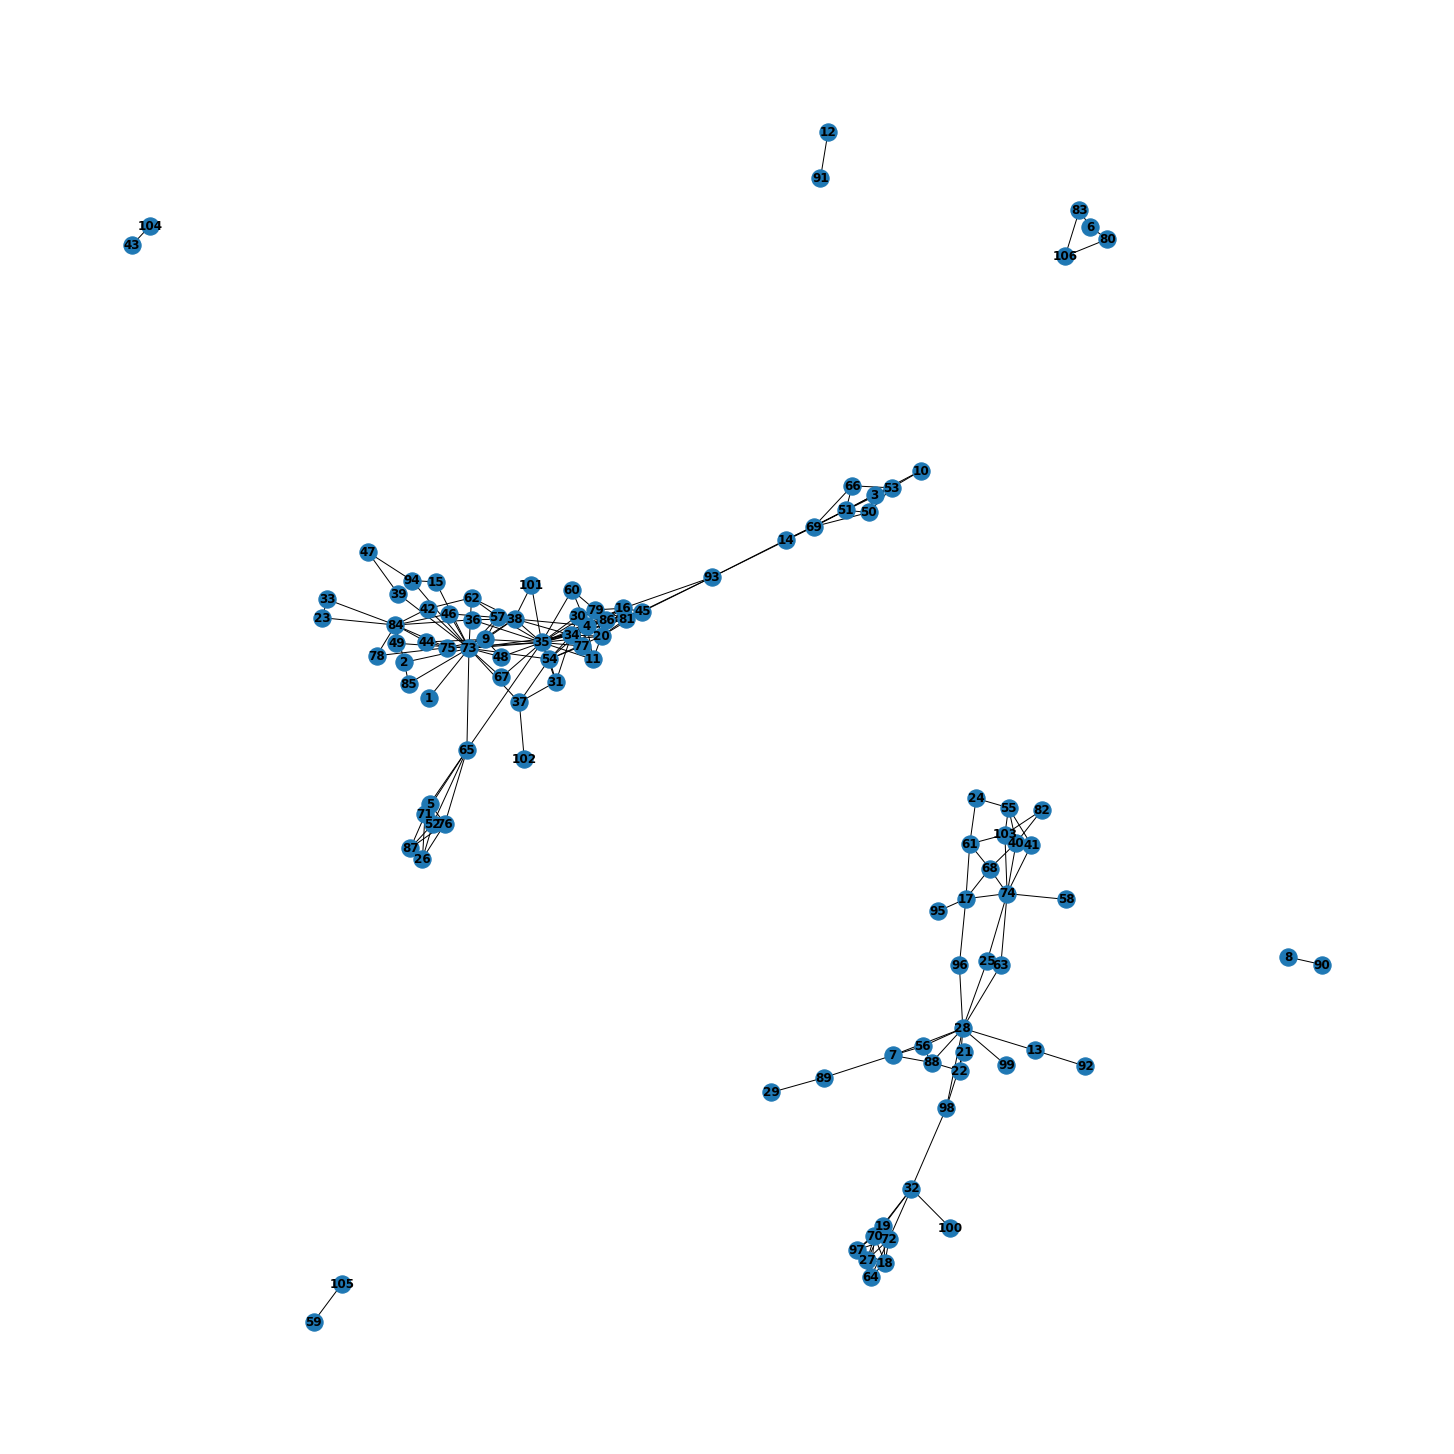

In [594]:
G,mapping = create_graph(similarity_df)

# Set the figure size
plt.figure(figsize=(20, 20))

# Visualize the graph
pos = nx.spring_layout(G)  # Adjust the layout method if needed
nx.draw(G, pos=pos, with_labels=True, font_weight='bold')

plt.show()


### 1.6 Coummunity detection

In [543]:
### Using Girvan newman
communities_temp = girvan_newman(G)
 
communities = []
for com in next(communities_temp):
    communities.append(list(com))
    
print(communities)
# Calculate modularity
mod = nx.algorithms.community.modularity(G, communities)
print("Modularity:", mod)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143], [35, 43, 142, 144, 82, 21, 90, 30]]
Modularity: 0.022649704142011895


In [628]:
### Using Girvan newman
communities_temp = girvan_newman(G)
 
communities = []
for com in next(communities_temp):
    communities.append(list(com))
    
print(communities)
# Calculate modularity
mod = nx.algorithms.community.modularity(G, communities)
print("Modularity:", mod)

color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]:
        color_map.append('green')  
    elif node in node_groups[2]:
        color_map.append('red') 
    elif node in node_groups[3]:
        color_map.append('black') 
    elif node in node_groups[4]:
        color_map.append('pink') 
    else:
        color_map.append('orange') 
plt.figure(figsize=(20, 20))
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

[[1, 2, 4, 5, 9, 11, 15, 16, 20, 23, 26, 30, 31, 33, 34, 35, 36, 37, 38, 39, 42, 44, 45, 46, 47, 48, 49, 52, 54, 57, 60, 62, 65, 67, 71, 73, 75, 76, 77, 78, 79, 81, 84, 85, 86, 87, 93, 94, 101, 102], [66, 3, 69, 10, 14, 50, 51, 53], [80, 106, 83, 6], [7, 13, 17, 18, 19, 21, 22, 24, 25, 27, 28, 29, 32, 40, 41, 55, 56, 58, 61, 63, 64, 68, 70, 72, 74, 82, 88, 89, 92, 95, 96, 97, 98, 99, 100, 103], [8, 90], [91, 12], [104, 43], [105, 59]]
Modularity: 0.5396831145314624


NameError: name 'node_groups' is not defined

#### 1.6.2 Using asynchronous label propagation

[{1, 4, 11, 16, 20, 30, 31, 34, 35, 37, 45, 48, 49, 54, 60, 67, 73, 77, 79, 81, 86, 93, 102}, {2, 85, 94, 15}, {66, 3, 69, 10, 14, 50, 51, 53}, {65, 5, 71, 76, 52, 87, 26}, {83, 6}, {99, 7, 22, 56, 25, 88, 28, 63}, {8, 90}, {36, 101, 38, 9, 57, 62}, {91, 12}, {92, 13}, {96, 68, 103, 40, 41, 74, 17, 82, 55, 24, 58, 61, 95}, {32, 64, 97, 100, 70, 72, 18, 19, 27}, {98, 21}, {33, 23}, {89, 29}, {47, 39}, {42, 75, 44, 78, 46, 84}, {104, 43}, {105, 59}, {80, 106}]
Modularity: 0.6423358985966501


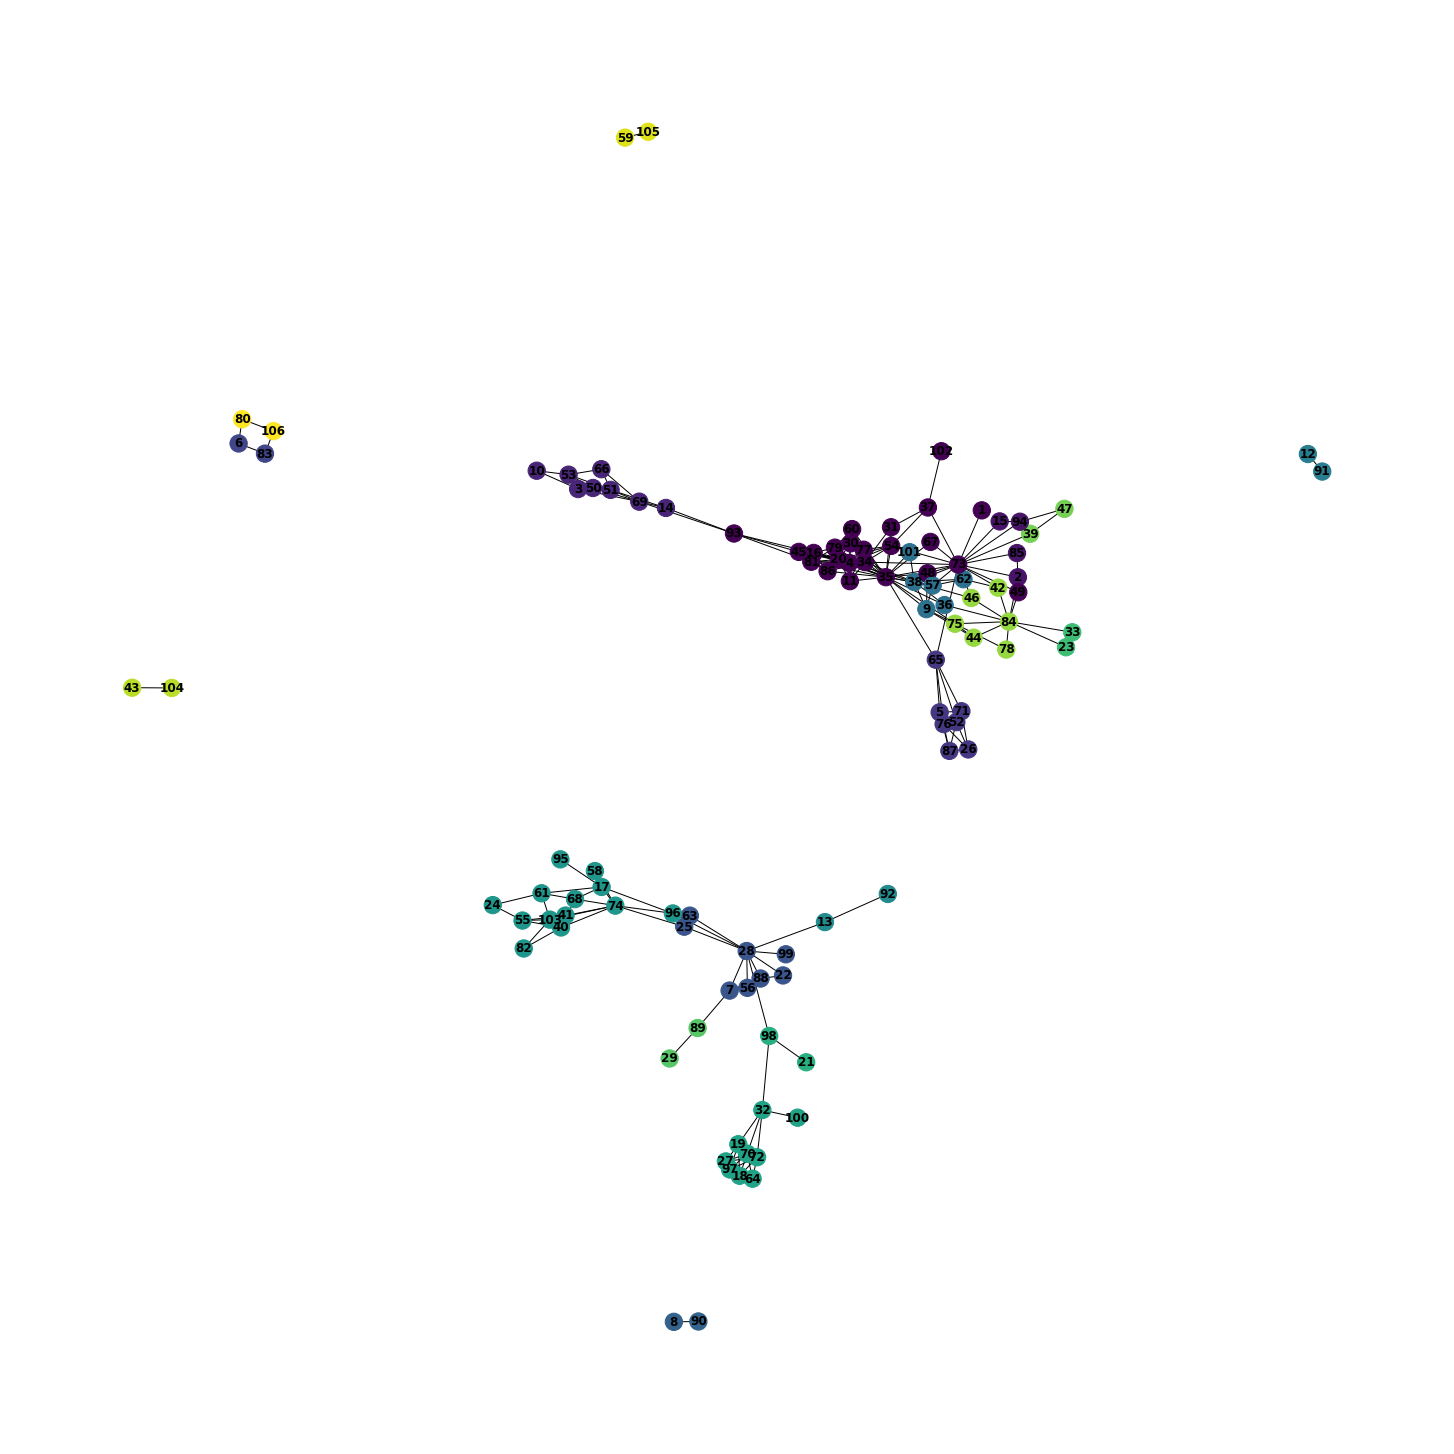

In [604]:
# Detect communities using asynchronous label propagation
communities = list(asyn_lpa_communities(G))
print(communities)

# Assign community laabels to nodes
community_labels = {node: idx for idx, nodes in enumerate(communities) for node in nodes}

# Calculate modularity
mod = nx.algorithms.community.modularity(G, communities)
print("Modularity:", mod)


# Set the figure size
plt.figure(figsize=(20, 20))

# Visualize the graph with community colors
node_colors = [community_labels[node] for node in G.nodes]
nx.draw(G, pos=nx.spring_layout(G), with_labels=True, font_weight='bold', node_color=node_colors, cmap=plt.cm.get_cmap("viridis"))

plt.show()


In [640]:
start_time = time.time()
del_files('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/trained_models')
del_files('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions')

second_approach_trained_models_folder_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions/"

columns_to_consider = ['MPN_Liste_TruncateBegin20','EAN_Liste_TruncateBegin20','Produktname_dic3',
                       'Modell_Liste_3g','Digital_zoom_NumMaxProz30','optischer_zoom_NumMaxProz30', 
                       'Breite_NumMaxProz30','Höhe_NumMaxProz30', 'Gewicht_NumMaxProz30', 
                       'Sensortyp_Jaccard3','is_match']


community_count = 1
count_of_labeled_record_pairs = 0
count_of_all_record_pairs = 0
for community in communities:
    if(len(community)>1):
        print(f"we are now in the {community_count} community ")
        print(community)
        community_count = community_count + 1 
        overall_accuracy = []
        community_df,belong_to_files = tf_pre_processing_new(community,similarity_df,mapping)

        community_candidate_models = community_df['first_file']
        for candidate_model in community_candidate_models:
            print(f"The candidate model that should be processed is {candidate_model}")
            coressponding_to_predict_files = belong_to_files.loc[belong_to_files['first_file']== candidate_model]['belong_to']
            # Now , we want to check , whether the the obveroed candidate file has alreaday been predicted by 
            # another model or not.... if there are predictions for the file , we do not need to do manual labeling
            if os.path.isfile(second_approach_trained_models_folder_path + candidate_model):
               print("Used already labeled dataset")
               # The file was already predicted by another model 
               candidate_model_df = pd.read_csv(second_approach_trained_models_folder_path + candidate_model)
               candidate_model_df_processed = prepare_dataframe_supervised_approach(candidate_model_df)
               #columns_except_exclude_column = ['Produktname_dic3','Modell_Liste_3g']
               #candidate_model_df_processed['closest_match_ratio'] = candidate_model_df_processed.apply(lambda row: calcualte_ratio(row,candidate_model_df_processed,columns_except_exclude_column), axis=1)
               #candidate_model_df_processed = candidate_model_df_processed.loc[candidate_model_df_processed['closest_match_ratio'] > 0.9]
               #candidate_model_df_processed.drop(columns=['closest_match_ratio'], axis=1, inplace=True)
               X = candidate_model_df_processed.iloc[:, :-2] 
               y = candidate_model_df_processed.iloc[: , -2] 


            else:
               print("The dataset was manually labeled")
               # The file was not predicted by another file
               candidate_model_df = pd.read_csv(path_to_sim_vector_folder + candidate_model)
               candidate_model_df_processed = prepare_dataframe_prediction(candidate_model_df)
               print(f"The original model shape is {candidate_model_df_processed.shape[0]}")
               if(candidate_model_df_processed.shape[0]>200) and (candidate_model not in ['www.buzzillions.com_www.wexphotographic.com.csv','www.buzzillions.com_www.henrys.com.csv','www.canon-europe.com_cammarkt.com.csv','www.camerafarm.com.au_www.garricks.com.au.csv','www.camerafarm.com.au_cammarkt.com.csv','www.garricks.com.au_www.price-hunt.com.csv','www.henrys.com_www.price-hunt.com.csv','www.canon-europe.com_www.priceme.co.nz.csv','buy.net_www.price-hunt.com.csv','www.henrys.com_www.priceme.co.nz.csv','www.canon-europe.com_www.gosale.com.csv','www.camerafarm.com.au_www.gosale.com.csv']):
                   candidate_model_df_processed,active_learning_labeled_data = active_learning_new(candidate_model_df_processed)
                   print(f"After active learning process the number is {active_learning_labeled_data}")
                   X = candidate_model_df_processed.iloc[:, 2:-2] 
                   y = candidate_model_df_processed.iloc[: , -1] 
               #if candidate_model != 'www.camerafarm.com.au_www.ilgs.net.csv':
               #     columns_except_exclude_column = ['Produktname_dic3','Modell_Liste_3g']
               #     candidate_model_df_processed['closest_match_ratio'] = candidate_model_df_processed.apply(lambda row: calcualte_ratio(row,candidate_model_df_processed,columns_except_exclude_column), axis=1)
               #     candidate_model_df_processed = candidate_model_df_processed.loc[candidate_model_df_processed['closest_match_ratio'] > 0.9]
               #     candidate_model_df_processed.drop(columns=['closest_match_ratio'], axis=1, inplace=True)
               else:
                   X = candidate_model_df_processed.iloc[:, 2:-1] 
                   y = candidate_model_df_processed.iloc[: , -1] 
               count_of_labeled_record_pairs = count_of_labeled_record_pairs + active_learning_labeled_data
               count_of_all_record_pairs = count_of_all_record_pairs + candidate_model_df_processed.shape[0]
               #count_of_labeled_record_pairs = count_of_labeled_record_pairs + candidate_model_df_processed.shape[0]
               #count_of_all_record_pairs = count_of_all_record_pairs + candidate_model_df_processed.shape[0]
               candidate_model_df_processed.to_csv(os.path.join(second_approach_trained_models_folder_path,candidate_model))



            model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
            model.fit(X, y)

            # Iterate over the files in the Cluster
            for coressponding_to_predict_file in coressponding_to_predict_files:
                 if (coressponding_to_predict_file != candidate_model) and (pd.notna(coressponding_to_predict_file)):
                     print(coressponding_to_predict_file)
                     # Prepare the data of the file
                     coressponding_to_predict_file_df = pd.read_csv(path_to_sim_vector_folder + coressponding_to_predict_file)
                     coressponding_to_predict_file_df_processed = prepare_dataframe_prediction(coressponding_to_predict_file_df)

                     X = coressponding_to_predict_file_df_processed.iloc[:, 2:-1] # Features (all columns except the last one)
                     y = coressponding_to_predict_file_df_processed.iloc[: , -1] # Taregt variable (is_match)   
                     count_of_all_record_pairs = count_of_all_record_pairs + coressponding_to_predict_file_df_processed.shape[0]
                     # Prediction
                     predictions = model.predict(X)
                     class_probs = model.predict_proba(X)
                     coressponding_to_predict_file_df_processed['pred'] = predictions
                     coressponding_to_predict_file_df_processed[['probabilties_0', 'probabilties_1']] = class_probs
                     coressponding_to_predict_file_df_processed.to_csv(f'/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions/{coressponding_to_predict_file}')


print(f"The number of labeled record pairs is {count_of_labeled_record_pairs}")
print(f"The number of all record pairs is {count_of_all_record_pairs}")

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")





        

we are now in the 1 community 
[1, 2, 4, 5, 9, 11, 15, 16, 20, 23, 26, 30, 31, 33, 34, 35, 36, 37, 38, 39, 42, 44, 45, 46, 47, 48, 49, 52, 54, 57, 60, 62, 65, 67, 71, 73, 75, 76, 77, 78, 79, 81, 84, 85, 86, 87, 93, 94, 101, 102]
The candidate model that should be processed is www.ebay.com_www.priceme.co.nz.csv
The dataset was manually labeled
The original model shape is 33296
Elapsed time: 28.97673010826111 seconds
The used budget is 20
Elapsed time: 61.44506812095642 seconds
The used budget is 30
Elapsed time: 89.63693618774414 seconds
The used budget is 40
Elapsed time: 118.30797410011292 seconds
The used budget is 50
Elapsed time: 146.59180212020874 seconds
The used budget is 60
Elapsed time: 176.28972005844116 seconds
The used budget is 70
After active learning process the number is 70
www.ilgs.net_cammarkt.com.csv
www.ilgs.net_www.price-hunt.com.csv
www.mypriceindia.com_www.pcconnection.com.csv
www.ebay.com_www.eglobalcentral.co.uk.csv
www.camerafarm.com.au_www.mypriceindia.com.cs

# Comapre the results with the supervised results

### Mean and median of the record linkage tasks

In [547]:
shapes = []
csv_files = [file for file in os.listdir(path_to_sim_vector_folder) if file.endswith('.csv')]
for csv_file in csv_files:
    csv_file_path = os.path.join(path_to_sim_vector_folder,csv_file)
    file_df = pd.read_csv(csv_file_path)
    shapes.append(file_df.shape)
print(f"The length of the sim files is {np.sum(shapes)}")
print(f"The mean of the shape is {np.mean(shapes)}")
print(f"The median of the shape is {np.median(shapes)}")

The length of the sim files is 381359
The mean of the shape is 1306.0239726027398
The median of the shape is 21.5


In [590]:
second_approach_predictions_folder_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions/"
second_approach_predictions_models_folder_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/trained_models/"
# List to store individual DataFrames
dfs = []

# Iterate through each file in the folder
for file_name in os.listdir(second_approach_predictions_folder_path):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(second_approach_predictions_folder_path, file_name)
        # Read the CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path)
        df['record_compared_1'] = df['record_compared_1'] + "_" + file_name.split('_')[0]
        df['record_compared_2'] = df['record_compared_2'] + "_" + file_name.split('_')[1]
        dfs.append(df)
        
# Iterate through each file in the folder
for file_name in os.listdir(second_approach_predictions_models_folder_path):
    if file_name.endswith('.csv'):
         # Construct the full file path
        file_path = os.path.join(second_approach_predictions_models_folder_path, file_name)
        # Read the CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path)
        df['record_compared_1'] = df['record_compared_1'] + "_" + file_name.split('_')[0]
        df['record_compared_2'] = df['record_compared_2'] + "_" + file_name.split('_')[1]
        dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.loc[combined_df['pred'].isna(), 'pred'] = combined_df.loc[combined_df['pred'].isna(), 'is_match']
print(f"The shape is {combined_df.shape[0]}")
print(f"F1_score is {f1_score(combined_df['is_match'], combined_df['pred'])} ")
print(f"Precision is {precision_score(combined_df['is_match'], combined_df['pred'])} ")
print(f"Recall is {recall_score(combined_df['is_match'], combined_df['pred'])}")


The shape is 254584
F1_score is 0.9429412751580787 
Precision is 0.981950719922887 
Recall is 0.9069128218824419


In [642]:
start_time = time.time()
second_approach_predictions_folder_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions/"
second_approach_predictions_models_folder_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/trained_models/"
# List to store individual DataFrames
dfs = []

# Iterate through each file in the folder
for file_name in os.listdir(second_approach_predictions_folder_path):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(second_approach_predictions_folder_path, file_name)
        # Read the CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path)
        df['record_compared_1'] = df['record_compared_1'] + "_" + file_name.split('_')[0]
        df['record_compared_2'] = df['record_compared_2'] + "_" + file_name.split('_')[1]
        dfs.append(df)
        
# Iterate through each file in the folder
for file_name in os.listdir(second_approach_predictions_models_folder_path):
    if file_name.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(second_approach_predictions_models_folder_path, file_name)
        # Read the CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path)
        df['record_compared_1'] = df['record_compared_1'] + "_" + file_name.split('_')[0]
        df['record_compared_2'] = df['record_compared_2'] + "_" + file_name.split('_')[1]
        dfs.append(df)
# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)
candidate_model_df_processed = prepare_dataframe_prediction(combined_df)
print(candidate_model_df_processed.shape)
candidate_model_df_processed,active_learning_labeled_data = active_learning_new(candidate_model_df_processed)
print(f"The shape is {combined_df.shape[0]}")
print(f"F1_score is {f1_score(candidate_model_df_processed['is_match'], candidate_model_df_processed['pred'])} ")
print(f"Precision is {precision_score(candidate_model_df_processed['is_match'], candidate_model_df_processed['pred'])} ")
print(f"Recall is {recall_score(candidate_model_df_processed['is_match'], candidate_model_df_processed['pred'])}")

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

# fo each 10 221 seconds



(161514, 13)
Elapsed time: 137.93031907081604 seconds
The used budget is 20
Elapsed time: 282.5467121601105 seconds
The used budget is 30
Elapsed time: 426.0596601963043 seconds
The used budget is 40
Elapsed time: 578.3946802616119 seconds
The used budget is 50
Elapsed time: 735.9293539524078 seconds
The used budget is 60
Elapsed time: 885.44362616539 seconds
The used budget is 70
The shape is 161514
F1_score is 0.9487535722769711 
Precision is 0.9840665412298778 
Recall is 0.9158872010117997
Elapsed time: 886.1003568172455 seconds


In [641]:
def tf_pre_processing_new(community_values,similarity_df,mapping):
    community_keys = [key for key, value in mapping.items() if value in community_values]
    community_similarity_df = similarity_df[(similarity_df['first_file'].isin(community_keys)) & (similarity_df['second_file'].isin(community_keys))]

    community_similarity_df['first_file_count'] = community_similarity_df['first_file'].map(get_sim_vec_file_length)
    community_similarity_df['second_file_count'] = community_similarity_df['second_file'].map(get_sim_vec_file_length)
    
    max_index = community_similarity_df['first_file_count'].idxmax()

    # Get the value of column 'A' for the row with the maximum value in column 'B'
    value_of_column_A = community_similarity_df.loc[max_index, 'first_file']
    
    new_df = pd.DataFrame({'first_file': [value_of_column_A]})
    
    value_to_repeat = value_of_column_A
    repeated_values_df = pd.DataFrame({0: [value_to_repeat] * len(community_similarity_df['first_file_count'].unique())})
    
    unique_values_df1 = community_similarity_df['second_file'].unique()
    unique_values_df = pd.DataFrame({1: unique_values_df1})
    
    # Concatenate the two DataFrames column-wise
    new_df_2 = pd.concat([repeated_values_df, unique_values_df], axis=1)

    # Rename columns if needed
    new_df_2.columns = ['first_file', 'belong_to']
    
    new_df_2 = new_df_2[new_df_2['first_file'] != new_df_2['belong_to']]

    return new_df,new_df_2


# Evaluation

In [ ]:
################################ KS, All Features, alp ########################################################
KS, All Features, alp
Number of comparisons = 21170
The Number of similar feature vectors is 124
The Number of record linkage tasks that have at least one similar other record linkage task is 49


Active_learning = 100
The shape is 42587
The number of labeled record pairs is 1600
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9638451521250148 
Precision is 0.9674874037456032 
Recall is 0.9602302212577252
Elapsed time: 710.652645111084 seconds
Supervised Learning
F1_score is 0.9814884954076318 
Precision is 0.9849859837506533 
Recall is 0.9780157569467377
Elapsed time: 27200 seconds


Active_learning = 90
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1440
The number of all record pairs is 42587
F1_score is 0.9687296887412437 
Precision is 0.9890385371608337 
Recall is 0.9492380997310941
Elapsed time: 677.8289406299591 seconds
Supervised Learning
F1_score is 0.9812922347362181 
Precision is 0.9864143388311565 
Recall is 0.9762230504316649
Elapsed time: 23800 seconds
    

Active_learning = 80
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1280
The number of all record pairs is 42587
F1_score is 0.9603920162543325 
Precision is 0.9733985851342184 
Recall is 0.9477284521394537
Elapsed time: 588.4484190940857 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9809902113775004 
Precision is 0.9833151632933592 
Recall is 0.9786762277680804
Elapsed time: 20400 seconds

Active_learning = 70
The shape is 42587
The number of labeled record pairs is 1120
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9670482636138911 
Precision is 0.9842208109428432 
Recall is 0.9504646883993018
Elapsed time: 540.5665009021759 seconds
Supervised Learning
F1_score is 0.9758361644097804 
Precision is 0.9899519440803844 
Recall is 0.9621172807472755
Elapsed time: 18700 seconds
    

Active_learning = 60
The number of labeled record pairs is 960
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9240263780017419 
Precision is 0.9777754371181799 
Recall is 0.8758786620748219
Elapsed time: 480.5665009021759 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9795918367346939 
Precision is 0.984375 
Recall is 0.9748549323017408
Elapsed time: 15300 seconds
    

Active_learning = 50
The number of labeled record pairs is 800
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9595255386105059 
Precision is 0.9853825883756774 
Recall is 0.9349908005849884
Elapsed time: 401.5665009021759 seconds
Supervised Learning
F1_score is 0.9779336825389301 
Precision is 0.9826617128703439 
Recall is 0.9732509317356229
Elapsed time: 13600 seconds


################################ KS, All Features, newmann ########################################################
Active_learning = 100
The shape is 42587
The number of labeled record pairs is 1600
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9638451521250148 
Precision is 0.9674874037456032 
Recall is 0.9602302212577252
Elapsed time: 351.39159393310547 seconds
Supervised Learning
F1_score is 0.9814884954076318 
Precision is 0.9849859837506533 
Recall is 0.9780157569467377
Elapsed time: 21920 seconds


Active_learning = 90
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1440
The number of all record pairs is 42587
F1_score is 0.9687296887412437 
Precision is 0.9890385371608337 
Recall is 0.9492380997310941
Elapsed time: 273.7747859954834 seconds
Supervised Learning
F1_score is 0.9812922347362181 
Precision is 0.9864143388311565 
Recall is 0.9762230504316649
Elapsed time: 19728 seconds

Active_learning = 80
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1280
The number of all record pairs is 42587
F1_score is 0.9603920162543325 
Precision is 0.9733985851342184 
Recall is 0.9477284521394537
Elapsed time: 180.5660629272461 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9809902113775004 
Precision is 0.9833151632933592 
Recall is 0.9786762277680804
Elapsed time: 16440 seconds

Active_learning = 70
The shape is 42587
The number of labeled record pairs is 1120
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9670482636138911 
Precision is 0.9842208109428432 
Recall is 0.9504646883993018
Elapsed time: 100.0949192047119 seconds
Supervised Learning
F1_score is 0.9758361644097804 
Precision is 0.9899519440803844 
Recall is 0.9621172807472755
Elapsed time: 15970 seconds


Active_learning = 60
The number of labeled record pairs is 960
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9240263780017419 
Precision is 0.9777754371181799 
Recall is 0.8758786620748219
Elapsed time: 92.0949192047119 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9795918367346939 
Precision is 0.984375 
Recall is 0.9748549323017408
Elapsed time: 12330 seconds


Active_learning = 50
The number of labeled record pairs is 800
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9595255386105059 
Precision is 0.9853825883756774 
Recall is 0.9349908005849884
Elapsed time: 73.0949192047119 seconds
Supervised Learning
F1_score is 0.9779336825389301 
Precision is 0.9826617128703439 
Recall is 0.9732509317356229
Elapsed time: 10960 seconds



################################ KS, Majority of the Features, alp ########################################################
Number of comparisons = 21170
The Number of similar feature vectors is 2600
The Number of record linkage tasks that have at least one similar other record linkage task is 144
Active_learning = 100
The shape is 315923
The number of labeled record pairs is 300
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9529950510298375 
Precision is 0.9878946994962038 
Recall is 0.9204770846005342
Elapsed time: 701 seconds
One single model
F1_score is 0.9649880610629678 
Precision is 0.9791740396918303 
Recall is 0.9512072567635469
Elapsed time: 8160 seconds
    
Active_learning = 90
The shape is 315923
The number of labeled record pairs is 270
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9565593001473183 
Precision is 0.974116535783079 
Recall is 0.9396237538857327
Elapsed time: 665 seconds
One single model
F1_score is 0.9577296666848906 
Precision is 0.977339507550398 
Recall is 0.9388912709472255
Elapsed time:7344 seconds
    
    
Active_learning = 80
The shape is 315923
The number of labeled record pairs is 240
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9402406024842694 
Precision is 0.9822601520002335 
Recall is 0.9016686318647944
Elapsed time: 555.617240190506 seconds
One single model
F1_score is 0.9487374841650174 
Precision is 0.9577049448899163 
Recall is 0.9399363990424126
Elapsed time:6825 seconds
    
    
Active_learning = 70
The shape is 315923
The number of labeled record pairs is 210
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9420838385188804 
Precision is 0.9734016709695243 
Recall is 0.9127184049737378
Elapsed time: 479.617240190506 seconds
One single model
F1_score is 0.9439781977006515 
Precision is 0.9537381473377097 
Recall is 0.934415978847322
Elapsed time:5712 seconds
    
    
Active_learning = 60
The shape is 315923
The number of labeled record pairs is 180
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9402509571584272 
Precision is 0.9823357664233576 
Recall is 0.901623968270983
Elapsed time: 403.617240190506 seconds
One single model
F1_score is 0.9331476952702978 
Precision is 0.9445781588893668 
Recall is 0.9219905670489871
Elapsed time:4896 seconds
    
    
Active_learning = 50
The shape is 315923
The number of labeled record pairs is 150
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9367417637131196 
Precision is 0.9826586760566143 
Recall is 0.8949244291992711
Elapsed time: 323.617240190506 seconds
One single model
F1_score is 0.9402509571584272 
Precision is 0.9823357664233576 
Recall is 0.901623968270983
Elapsed time:4080 seconds
    

    
################################ KS, Majority of the Features, newman ########################################################
Active_learning = 100
The shape is 254584
The number of labeled record pairs is 200
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.956982561422924 
Precision is 0.9817530635892274 
Recall is 0.9334312612672765
Elapsed time: 439.7308700084686 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time: 4420.7308700084686 seconds
    
Active_learning = 90
The shape is 254584
The number of labeled record pairs is 180
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.956982561422924 
Precision is 0.9817530635892274 
Recall is 0.9334312612672765
Elapsed time: 388.2493760585785 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:3978 seconds
    
    
Active_learning = 80
The shape is 254584
The number of labeled record pairs is 160
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9484551507443705 
Precision is 0.9820996555792585 
Recall is 0.9170394605061094
Elapsed time: 341.617240190506 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:3536 seconds
    
    
Active_learning = 70
The shape is 254584
The number of labeled record pairs is 140
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9484551507443705 
Precision is 0.9820996555792585 
Recall is 0.9170394605061094
Elapsed time: 300 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:3094 seconds
    
    
Active_learning = 60
The shape is 254584
The number of labeled record pairs is 120
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9385051925374506 
Precision is 0.969857777144621 
Recall is 0.909116200396163
Elapsed time: 243.617240190506 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:2652 seconds
    
    
Active_learning = 50
The shape is 254584
The number of labeled record pairs is 100
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9331476952702978 
Precision is 0.9445781588893668 
Recall is 0.9219905670489871
Elapsed time: 216.617240190506 seconds
One single model
F1_score is 0.9402509571584272 
Precision is 0.9823357664233576 
Recall is 0.901623968270983
Elapsed time:2210 seconds
    
    
    
    
    
    

In [125]:
################################ Wasserstein=0.95, All Features, alp ########################################################
Number of comparisons = 21170
The Number of similar feature vectors is 584
The Number of record linkage tasks that have at least one similar other record linkage task is 126
Active_learning = 100
The shape is 369903
The number of labeled record pairs is 2100
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9433974205389474 
Precision is 0.9546394393515215 
Recall is 0.9324170963389243
Supervised Learning
F1_score is 0.9619335075232003 
Precision is 0.9699472168470016 
Recall is 0.9540511317433226


Active_learning = 90
The shape is 369903
The number of labeled record pairs is 1890
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9346517350012647 
Precision is 0.9814836279339322 
Recall is 0.8920855098547035
Supervised Learning
F1_score is 0.9625351587882204 
Precision is 0.9791801490301943 
Recall is 0.946446602982834


Active_learning = 80
The shape is 369903
The number of labeled record pairs is 1680
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9411081534337705 
Precision is 0.9800584410558093 
Recall is 0.9051355143109904
Supervised Learning
F1_score is 0.9668206788663731 
Precision is 0.9722323845759859 
Recall is 0.9614688856729378



Active_learning = 70
The shape is 369903
The number of labeled record pairs is 1470
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9411204311514155 
Precision is 0.9557801817076093 
Recall is 0.9269035895877827
Supervised Learning
F1_score is 0.9618488462734248 
Precision is 0.9700707105593224 
Recall is 0.9537651800155487



Active_learning = 60
The shape is 369903
The number of labeled record pairs is 1260
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9328488961841352 
Precision is 0.9823362044688723 
Recall is 0.8881085114788639
Supervised Learning
F1_score is 0.9608042747456101 
Precision is 0.973110198694919 
Recall is 0.9488057047369691


Active_learning = 50
The shape is 369903
The number of labeled record pairs is 1050
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.8893257920056227 
Precision is 0.9489996554030771 
Recall is 0.8367126274495786
Supervised Learning
F1_score is 0.9604840577998447 
Precision is 0.976790597974721 
Recall is 0.9447130206332044


################################ Wasserstein=0.95, All Features, newman ########################################################
Number of comparisons = 21170
The Number of similar feature vectors is 584
The Number of record linkage tasks that have at least one similar other record linkage task is 126
Active_learning = 100
The shape is 369903
The number of labeled record pairs is 800
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9444983585852724 
Precision is 0.9824766467991384 
Recall is 0.9093469475340653
Supervised Learning
F1_score is 0.9513454296473811 
Precision is 0.9718085255196725 
Recall is 0.9317263331068274


Active_learning = 90
The shape is 369903
The number of labeled record pairs is 720
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9135207394027091 
Precision is 0.9841532029112683 
Recall is 0.8523479131647652
Supervised Learning
F1_score is 0.9446394815014855 
Precision is 0.9855435733022443 
Recall is 0.9069954579593005
## Continue here


Active_learning = 80
The shape is 369903
The number of labeled record pairs is 1680
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9411081534337705 
Precision is 0.9800584410558093 
Recall is 0.9051355143109904
Supervised Learning
F1_score is 0.9668206788663731 
Precision is 0.9722323845759859 
Recall is 0.9614688856729378



Active_learning = 70
The shape is 369903
The number of labeled record pairs is 1470
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.9213528360332033 
Precision is 0.9898852793613448 
Recall is 0.8616953306201042
Supervised Learning
F1_score is 0.9618488462734248 
Precision is 0.9700707105593224 
Recall is 0.9537651800155487



Active_learning = 60
The shape is 369903
The number of labeled record pairs is 1260
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.938115252224418 
Precision is 0.9754570450050649 
Recall is 0.9035270358422619
Supervised Learning
F1_score is 0.9608042747456101 
Precision is 0.973110198694919 
Recall is 0.9488057047369691


Active_learning = 50
The shape is 369903
The number of labeled record pairs is 1050
The number of all record pairs is 369903
Transfear Learning
F1_score is 0.8893257920056227 
Precision is 0.9489996554030771 
Recall is 0.8367126274495786
Supervised Learning
F1_score is 0.9446394815014855 
Precision is 0.9855435733022443 
Recall is 0.9069954579593005


################################ Wasserstein=0.95, Majority of the Features, alp ########################################################
Number of comparisons = 21170
The Number of similar feature vectors is 3174
The Number of record linkage tasks that have at least one similar other record linkage task is 146
Active_learning = 100
The shape is 377248
The number of labeled record pairs is 400
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9496618348901074 
Precision is 0.9615055834000702 
Recall is 0.9381063166673983
Supervised Learning
F1_score is 0.9483676098254343 
Precision is 0.9597932119577434 
Recall is 0.9372108335893947


Active_learning = 90
The shape is 377248
The number of labeled record pairs is 360
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9436894104550304 
Precision is 0.9811155155618568 
Recall is 0.9090137346189247
Supervised Learning
F1_score is 0.9561354455126628 
Precision is 0.9748047872728599 
Recall is 0.9381677713884378


Active_learning = 80
The shape is 377248
The number of labeled record pairs is 320
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9411081534337705 
Precision is 0.9800584410558093 
Recall is 0.9051355143109904
Supervised Learning
F1_score is 0.9561354455126628 
Precision is 0.9748047872728599 
Recall is 0.9381677713884378



Active_learning = 70
The shape is 377248
The number of labeled record pairs is 280
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.936726347359811 
Precision is 0.970919881305638 
Recall is 0.9048593125850489
Supervised Learning
F1_score is 0.940464767753196 
Precision is 0.9805539411377993 
Recall is 0.9035248672139063



Active_learning = 60
The shape is 377248
The number of labeled record pairs is 240
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9268384686864598 
Precision is 0.9735400137228563 
Recall is 0.8844124489706334
Supervised Learning
F1_score is 0.9555580412071318 
Precision is 0.9743248175182482 
Recall is 0.9375005487028665


Active_learning = 50
The shape is 377248
The number of labeled record pairs is 200
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9449240045332986 
Precision is 0.96468554494567 
Recall is 0.9259558403933102
Supervised Learning
F1_score is 0.9578484310349491 
Precision is 0.984216522633173 
Recall is 0.9328563276414557



################################ Wasserstein=0.95, Majority of the Features, newman ########################################################
Number of comparisons = 21170
The Number of similar feature vectors is 3174
The Number of record linkage tasks that have at least one similar other record linkage task is 146
Active_learning = 100
The shape is 377248
The number of labeled record pairs is 200
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9364724631575092 
Precision is 0.9821145552172285 
Recall is 0.8948842501422257
Supervised Learning
F1_score is 0.9559653035490718 
Precision is 0.9808917783998822 
Recall is 0.9322742987177804


Active_learning = 90
The shape is 377523
The number of labeled record pairs is 180
The number of all record pairs is 377523
Transfear Learning
F1_score is 0.9402877500935143 
Precision is 0.9819079104065243 
Recall is 0.902052426589646
Supervised Learning
F1_score is 0.9416832969051918 
Precision is 0.9811313638035248 
Recall is 0.9052847721300921


## new here
Active_learning = 80
The shape is 377248
The number of labeled record pairs is 160
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9358521349777038 
Precision is 0.9822692988532287 
Recall is 0.8936239114261958
Supervised Learning 
F1_score is 0.935473653769354 
Precision is 0.9836090893294979 
Recall is 0.8918296792262921



Active_learning = 70
The shape is 377248
The number of labeled record pairs is 140
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.936726347359811 
Precision is 0.970919881305638 
Recall is 0.9048593125850489
Supervised Learning
F1_score is 0.9345693304072266 
Precision is 0.9549589871937741 
Recall is 0.9150321648943154


Active_learning = 60
The shape is 377248
The number of labeled record pairs is 120
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9172333353310804 
Precision is 0.969051979426434 
Recall is 0.8706752439718174
Supervised Learning
F1_score is 0.9440966819842964 
Precision is 0.9768534551342649 
Recall is 0.9134654938514726


Active_learning = 50
The shape is 377248
The number of labeled record pairs is 200
The number of all record pairs is 377248
Transfear Learning
F1_score is 0.9449240045332986 
Precision is 0.96468554494567 
Recall is 0.9259558403933102
Supervised Learning
F1_score is 0.9578484310349491 
Precision is 0.984216522633173 
Recall is 0.9328563276414557









SyntaxError: invalid syntax (3273043368.py, line 2)

In [ ]:
################################ KS, All Features, alp ########################################################
KS, All Features, alp
Number of comparisons = 21170
The Number of similar feature vectors is 124
The Number of record linkage tasks that have at least one similar other record linkage task is 49


Active_learning = 100
The shape is 42587
The number of labeled record pairs is 1600
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9638451521250148 
Precision is 0.9674874037456032 
Recall is 0.9602302212577252
Elapsed time: 710.652645111084 seconds
Supervised Learning
F1_score is 0.9814884954076318 
Precision is 0.9849859837506533 
Recall is 0.9780157569467377
Elapsed time: 27200 seconds


Active_learning = 90
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1440
The number of all record pairs is 42587
F1_score is 0.9687296887412437 
Precision is 0.9890385371608337 
Recall is 0.9492380997310941
Elapsed time: 677.8289406299591 seconds
Supervised Learning
F1_score is 0.9812922347362181 
Precision is 0.9864143388311565 
Recall is 0.9762230504316649
Elapsed time: 23800 seconds
    

Active_learning = 80
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1280
The number of all record pairs is 42587
F1_score is 0.9603920162543325 
Precision is 0.9733985851342184 
Recall is 0.9477284521394537
Elapsed time: 588.4484190940857 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9809902113775004 
Precision is 0.9833151632933592 
Recall is 0.9786762277680804
Elapsed time: 20400 seconds

Active_learning = 70
The shape is 42587
The number of labeled record pairs is 1120
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9670482636138911 
Precision is 0.9842208109428432 
Recall is 0.9504646883993018
Elapsed time: 540.5665009021759 seconds
Supervised Learning
F1_score is 0.9758361644097804 
Precision is 0.9899519440803844 
Recall is 0.9621172807472755
Elapsed time: 18700 seconds
    

Active_learning = 60
The number of labeled record pairs is 960
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9240263780017419 
Precision is 0.9777754371181799 
Recall is 0.8758786620748219
Elapsed time: 480.5665009021759 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9795918367346939 
Precision is 0.984375 
Recall is 0.9748549323017408
Elapsed time: 15300 seconds
    

Active_learning = 50
The number of labeled record pairs is 800
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9595255386105059 
Precision is 0.9853825883756774 
Recall is 0.9349908005849884
Elapsed time: 401.5665009021759 seconds
Supervised Learning
F1_score is 0.9779336825389301 
Precision is 0.9826617128703439 
Recall is 0.9732509317356229
Elapsed time: 13600 seconds


################################ KS, All Features, newmann ########################################################
Active_learning = 100
The shape is 42587
The number of labeled record pairs is 1600
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9638451521250148 
Precision is 0.9674874037456032 
Recall is 0.9602302212577252
Elapsed time: 351.39159393310547 seconds
Supervised Learning
F1_score is 0.9814884954076318 
Precision is 0.9849859837506533 
Recall is 0.9780157569467377
Elapsed time: 21920 seconds


Active_learning = 90
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1440
The number of all record pairs is 42587
F1_score is 0.9687296887412437 
Precision is 0.9890385371608337 
Recall is 0.9492380997310941
Elapsed time: 273.7747859954834 seconds
Supervised Learning
F1_score is 0.9812922347362181 
Precision is 0.9864143388311565 
Recall is 0.9762230504316649
Elapsed time: 19728 seconds

Active_learning = 80
The shape is 42587
Transfear Learning
The number of labeled record pairs is 1280
The number of all record pairs is 42587
F1_score is 0.9603920162543325 
Precision is 0.9733985851342184 
Recall is 0.9477284521394537
Elapsed time: 180.5660629272461 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9809902113775004 
Precision is 0.9833151632933592 
Recall is 0.9786762277680804
Elapsed time: 16440 seconds

Active_learning = 70
The shape is 42587
The number of labeled record pairs is 1120
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9670482636138911 
Precision is 0.9842208109428432 
Recall is 0.9504646883993018
Elapsed time: 100.0949192047119 seconds
Supervised Learning
F1_score is 0.9758361644097804 
Precision is 0.9899519440803844 
Recall is 0.9621172807472755
Elapsed time: 15970 seconds


Active_learning = 60
The number of labeled record pairs is 960
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9240263780017419 
Precision is 0.9777754371181799 
Recall is 0.8758786620748219
Elapsed time: 92.0949192047119 seconds
Supervised Learning
The shape is 42587
F1_score is 0.9795918367346939 
Precision is 0.984375 
Recall is 0.9748549323017408
Elapsed time: 12330 seconds


Active_learning = 50
The number of labeled record pairs is 800
The number of all record pairs is 42587
Transfear Learning
F1_score is 0.9595255386105059 
Precision is 0.9853825883756774 
Recall is 0.9349908005849884
Elapsed time: 73.0949192047119 seconds
Supervised Learning
F1_score is 0.9779336825389301 
Precision is 0.9826617128703439 
Recall is 0.9732509317356229
Elapsed time: 10960 seconds



################################ KS, Majority of the Features, alp ########################################################
Number of comparisons = 21170
The Number of similar feature vectors is 2600
The Number of record linkage tasks that have at least one similar other record linkage task is 144
Active_learning = 100
The shape is 315923
The number of labeled record pairs is 300
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9529950510298375 
Precision is 0.9878946994962038 
Recall is 0.9204770846005342
Elapsed time: 701 seconds
One single model
F1_score is 0.9649880610629678 
Precision is 0.9791740396918303 
Recall is 0.9512072567635469
Elapsed time: 8160 seconds
    
Active_learning = 90
The shape is 315923
The number of labeled record pairs is 270
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9565593001473183 
Precision is 0.974116535783079 
Recall is 0.9396237538857327
Elapsed time: 665 seconds
One single model
F1_score is 0.9577296666848906 
Precision is 0.977339507550398 
Recall is 0.9388912709472255
Elapsed time:7344 seconds
    
    
Active_learning = 80
The shape is 315923
The number of labeled record pairs is 240
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9402406024842694 
Precision is 0.9822601520002335 
Recall is 0.9016686318647944
Elapsed time: 555.617240190506 seconds
One single model
F1_score is 0.9487374841650174 
Precision is 0.9577049448899163 
Recall is 0.9399363990424126
Elapsed time:6825 seconds
    
    
Active_learning = 70
The shape is 315923
The number of labeled record pairs is 210
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9420838385188804 
Precision is 0.9734016709695243 
Recall is 0.9127184049737378
Elapsed time: 479.617240190506 seconds
One single model
F1_score is 0.9439781977006515 
Precision is 0.9537381473377097 
Recall is 0.934415978847322
Elapsed time:5712 seconds
    
    
Active_learning = 60
The shape is 315923
The number of labeled record pairs is 180
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9402509571584272 
Precision is 0.9823357664233576 
Recall is 0.901623968270983
Elapsed time: 403.617240190506 seconds
One single model
F1_score is 0.9331476952702978 
Precision is 0.9445781588893668 
Recall is 0.9219905670489871
Elapsed time:4896 seconds
    
    
Active_learning = 50
The shape is 315923
The number of labeled record pairs is 150
The number of all record pairs is 315923
Transfear Learning
F1_score is 0.9367417637131196 
Precision is 0.9826586760566143 
Recall is 0.8949244291992711
Elapsed time: 323.617240190506 seconds
One single model
F1_score is 0.9402509571584272 
Precision is 0.9823357664233576 
Recall is 0.901623968270983
Elapsed time:4080 seconds
    

    
################################ KS, Majority of the Features, newman ########################################################
Active_learning = 100
The shape is 254584
The number of labeled record pairs is 200
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.956982561422924 
Precision is 0.9817530635892274 
Recall is 0.9334312612672765
Elapsed time: 439.7308700084686 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time: 4420.7308700084686 seconds
    
Active_learning = 90
The shape is 254584
The number of labeled record pairs is 180
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.956982561422924 
Precision is 0.9817530635892274 
Recall is 0.9334312612672765
Elapsed time: 388.2493760585785 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:3978 seconds
    
    
Active_learning = 80
The shape is 254584
The number of labeled record pairs is 160
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9484551507443705 
Precision is 0.9820996555792585 
Recall is 0.9170394605061094
Elapsed time: 341.617240190506 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:3536 seconds
    
    
Active_learning = 70
The shape is 254584
The number of labeled record pairs is 140
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9484551507443705 
Precision is 0.9820996555792585 
Recall is 0.9170394605061094
Elapsed time: 300 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:3094 seconds
    
    
Active_learning = 60
The shape is 254584
The number of labeled record pairs is 120
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9385051925374506 
Precision is 0.969857777144621 
Recall is 0.909116200396163
Elapsed time: 243.617240190506 seconds
One single model
F1_score is 0.9519183073054752 
Precision is 0.9760426531972359 
Recall is 0.9289577351939641
Elapsed time:2652 seconds
    
    
Active_learning = 50
The shape is 254584
The number of labeled record pairs is 100
The number of all record pairs is 254584
Transfear Learning
F1_score is 0.9331476952702978 
Precision is 0.9445781588893668 
Recall is 0.9219905670489871
Elapsed time: 216.617240190506 seconds
One single model
F1_score is 0.9402509571584272 
Precision is 0.9823357664233576 
Recall is 0.901623968270983
Elapsed time:2210 seconds
    
    
    
    
    
    

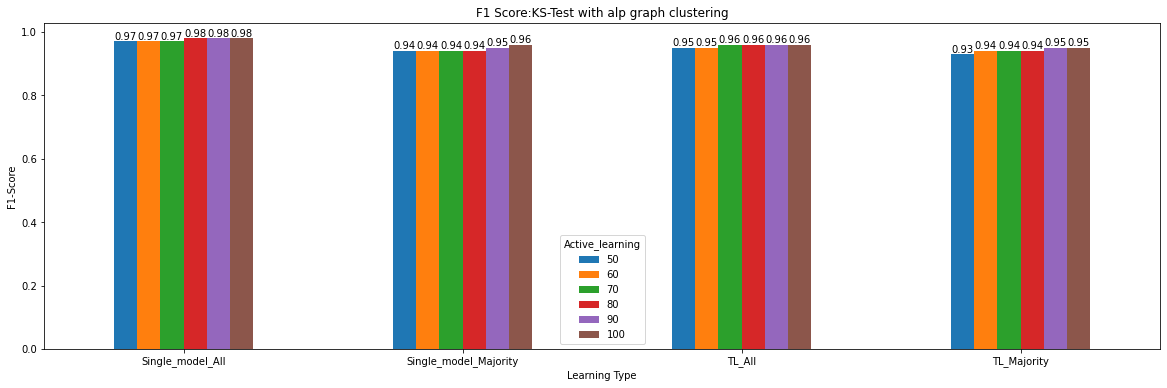

In [647]:
# KS-ALP:
Active_learning = [100,100,100,100,90,90,90,90,80,80,80,80,70,70,70,70,60,60,60,60,50,50,50,50]
F1_score= [0.96,0.95,0.98,0.96,0.96,0.95,0.98,0.95,0.96,0.94,0.98,0.94,0.96,0.94,0.97,0.94,0.95,0.94,0.97,0.94,0.95,0.93,0.97,0.94]
leanring_type = ['TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority']

df = pd.DataFrame({'Active_learning': Active_learning, 'F1_score': F1_score, 'leanring_type': leanring_type})

pivot_df = df.pivot('leanring_type','Active_learning','F1_score')

# Plot the bar plot
ax = pivot_df.plot.bar(figsize=(20, 6))

# Set x-axis label and rotate it horizontally
ax.set_xlabel('Learning Type')
ax.set_ylabel('F1-Score')
plt.xticks(rotation=0)
# Add title
plt.title('F1 Score:KS-Test with alp graph clustering')

# Write values of y axis above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    
# Show the plot
plt.show()






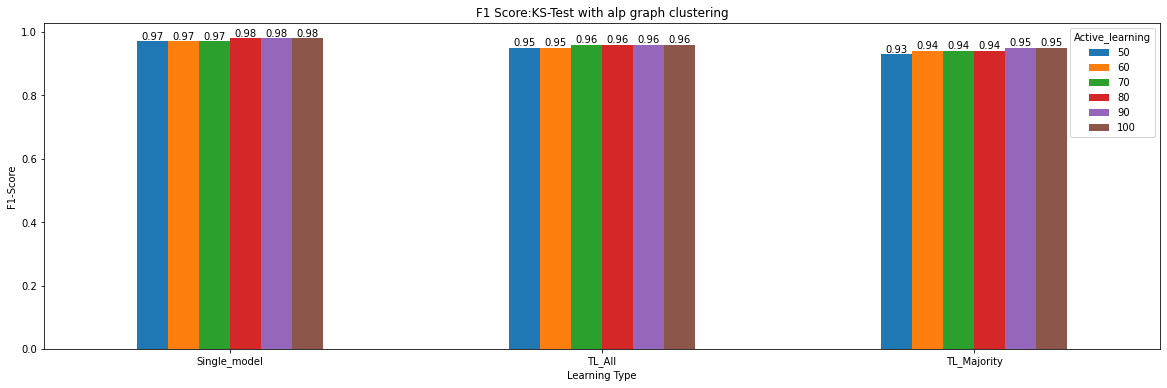

In [682]:
# KS-ALP:
Active_learning = [100,100,100,100,90,90,90,90,80,80,80,80,70,70,70,70,60,60,60,60,50,50,50,50]
F1_score= [0.96,0.95,0.98,0.96,0.96,0.95,0.98,0.95,0.96,0.94,0.98,0.94,0.96,0.94,0.97,0.94,0.95,0.94,0.97,0.94,0.95,0.93,0.97,0.94]
leanring_type = ['TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority']

df = pd.DataFrame({'Active_learning': Active_learning, 'F1_score': F1_score, 'leanring_type': leanring_type})

df = df[~df['leanring_type'].isin(['Single_model_Majority'])]
df['leanring_type'] = df['leanring_type'].replace({'Single_model_All': 'Single_model'})

pivot_df = df.pivot('leanring_type','Active_learning','F1_score')

# Plot the bar plot
ax = pivot_df.plot.bar(figsize=(20, 6))

# Set x-axis label and rotate it horizontally
ax.set_xlabel('Learning Type')
ax.set_ylabel('F1-Score')
plt.xticks(rotation=0)
# Add title
plt.title('F1 Score:KS-Test with alp graph clustering')

# Write values of y axis above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    
# Show the plot
plt.show()






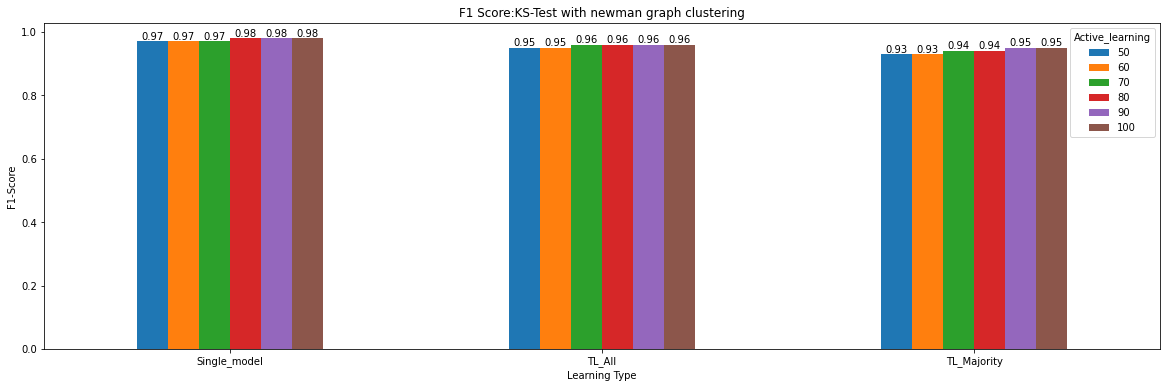

In [685]:
# KS-ALP:
Active_learning = [100,100,100,100,90,90,90,90,80,80,80,80,70,70,70,70,60,60,60,60,50,50,50,50]
F1_score= [0.96,0.95,0.98,0.95,0.96,0.95,0.98,0.95,0.96,0.94,0.98,0.95,0.96,0.94,0.97,0.95,0.95,0.93,0.97,0.95,0.95,0.93,0.97,0.94]
leanring_type = ['TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority']

df = pd.DataFrame({'Active_learning': Active_learning, 'F1_score': F1_score, 'leanring_type': leanring_type})
df = df[~df['leanring_type'].isin(['Single_model_Majority'])]
df['leanring_type'] = df['leanring_type'].replace({'Single_model_All': 'Single_model'})
pivot_df = df.pivot('leanring_type','Active_learning','F1_score')

# Plot the bar plot
ax = pivot_df.plot.bar(figsize=(20, 6))

# Set x-axis label and rotate it horizontally
ax.set_xlabel('Learning Type')
ax.set_ylabel('F1-Score')
plt.xticks(rotation=0)
# Add title
plt.title('F1 Score:KS-Test with newman graph clustering')

# Write values of y axis above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    
# Show the plot
plt.show()






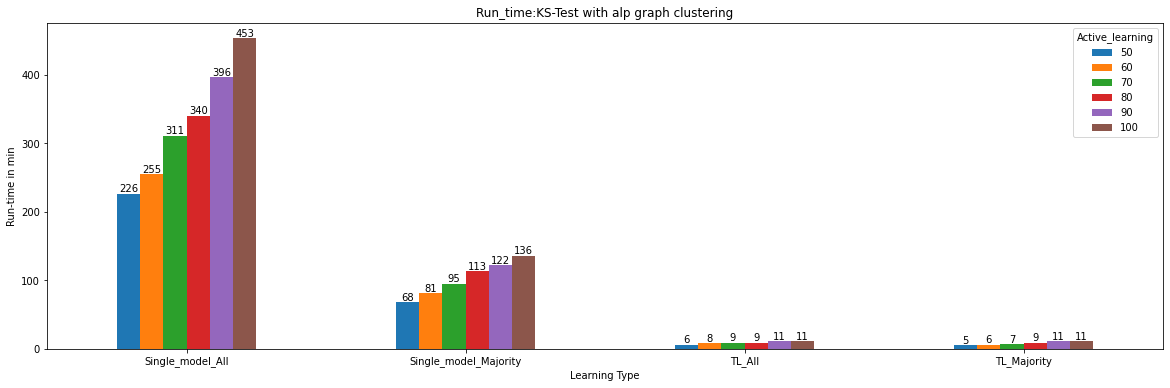

In [660]:
# KS-ALP:
Active_learning = [100,100,100,100,90,90,90,90,80,80,80,80,70,70,70,70,60,60,60,60,50,50,50,50]
run_time= [710,701,27200,8160,677,665,23800,7344,588,555,20400,6825,540,479,18700,5712,480,403,15300,4896,401,323,13600,4080]
leanring_type = ['TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority']

df = pd.DataFrame({'Active_learning': Active_learning, 'run_time': run_time, 'leanring_type': leanring_type})
df['run_time'] = df['run_time']//60
pivot_df = df.pivot('leanring_type','Active_learning','run_time')

# Plot the bar plot
ax = pivot_df.plot.bar(figsize=(20, 6))

# Set x-axis label and rotate it horizontally
ax.set_xlabel('Learning Type')
ax.set_ylabel('Run-time in min')
plt.xticks(rotation=0)
# Add title
plt.title('Run_time:KS-Test with alp graph clustering')

# Write values of y axis above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    
# Show the plot
plt.show()






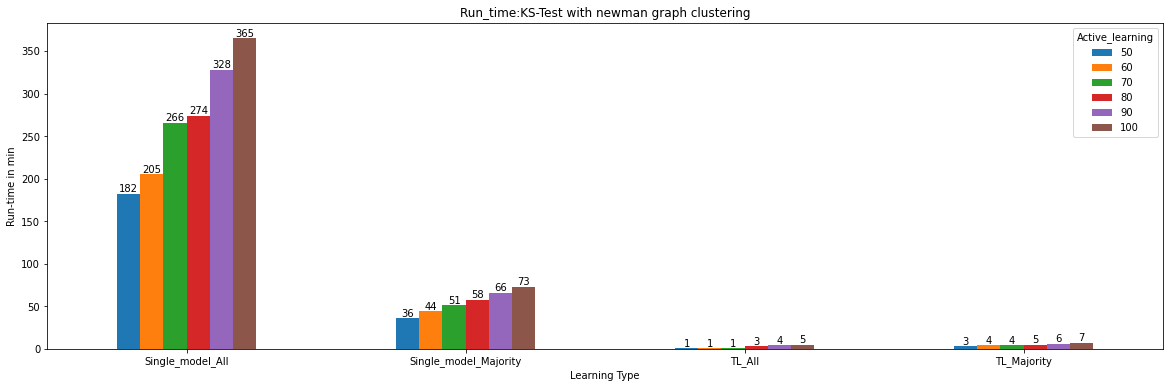

In [659]:
# KS-ALP:
Active_learning = [100,100,100,100,90,90,90,90,80,80,80,80,70,70,70,70,60,60,60,60,50,50,50,50]
run_time= [351,439,21920,4420,273,388,19728,3978,180,341,16440,3536,100,240,15970,3094,92,243,12330,2652,73,216,10960,2210]
leanring_type = ['TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority','TL_All','TL_Majority','Single_model_All','Single_model_Majority']

df = pd.DataFrame({'Active_learning': Active_learning, 'run_time': run_time, 'leanring_type': leanring_type})
df['run_time'] = df['run_time']//60
pivot_df = df.pivot('leanring_type','Active_learning','run_time')

# Plot the bar plot
ax = pivot_df.plot.bar(figsize=(20, 6))

# Set x-axis label and rotate it horizontally
ax.set_xlabel('Learning Type')
ax.set_ylabel('Run-time in min')
plt.xticks(rotation=0)
# Add title
plt.title('Run_time:KS-Test with newman graph clustering')

# Write values of y axis above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    
# Show the plot
plt.show()






# Archiv

In [ ]:
start_time = time.time()
del_files('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/trained_models')
del_files('/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions')

second_approach_trained_models_folder_path = "/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions/"

columns_to_consider = ['MPN_Liste_TruncateBegin20','EAN_Liste_TruncateBegin20','Produktname_dic3',
                       'Modell_Liste_3g','Digital_zoom_NumMaxProz30','optischer_zoom_NumMaxProz30', 
                       'Breite_NumMaxProz30','Höhe_NumMaxProz30', 'Gewicht_NumMaxProz30', 
                       'Sensortyp_Jaccard3','is_match']


community_count = 1
count_of_labeled_record_pairs = 0
count_of_all_record_pairs = 0
for community in communities:
    files_names = []
    dfs = []
    for node in community:
        # Get key based on value
        desired_key = None
        for key, value in mapping.items():
            if value == node:
                files_names.append(key)
                break
    
    for file_name in files_names:
         file_df = pd.read_csv(os.path.join(path_to_sim_vector_folder + file_name))
         file_df = prepare_dataframe_prediction(file_df)
         dfs.append(file_df)
   
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df_processed,active_learning_labeled_data = active_learning_new(combined_df)
    combined_df_processed.to_csv(f'/Users/abdulnaser/Desktop/Masterarbeit/metadatatransferlearning-main/meta_tl/data/second_approach_results/predictions/community_{community_count}.csv')
    community_count = community_count + 1 
    

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

    